In [77]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)
from collections import defaultdict

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path
from scipy.signal import hilbert, savgol_filter
from datetime import datetime

## Loading the pre-trained models

- version 1 - trained on curated PNSN + additional surface event. 
- version 2 - trained on curated PNSN + additional surface event + augmented
- version 3 - trained on curated PNSN + additional surface event + augmented + esec

In [314]:
model1 = sbm.SeismicCNN.from_pretrained("base", version_str = '1')
model2 = sbm.SeismicCNN.from_pretrained("base", version_str = '2')
model3 = sbm.SeismicCNN.from_pretrained("base", version_str = '3')

## Event detection algorithm

- First a window of 100s is run through continuous day streams at a stride of 10s. Make sure that this stream contains all three channels. 

- For each window, probabilities of eq, px, noise and surface events are calculated. 
- These probability series are then smoothed at an average of five samples while keeping the number of samples same. This is done to remove the isolated peaks. 

### The smoothing process 

A simple moving average is applied by taking five samples at a time. Ends are padded accordingly so that the output length matches with the input. 


### The detection process
In order to detect an event, an entry and exit threshold is applied to the smoothed probability series, with the additional condition that the maximum probability in this window is above certain value. 

If there are multiple overlapping windows, event is assigned the label with the highest mean probability. 



## Helper functions

In [315]:
# we want to smoothen out the probabilities here. 
def smooth_moving_avg(x, window=5):
    pad_width = window // 2
    padded = np.pad(x, (pad_width, pad_width), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')




def detect_event_windows(prob_series, enter_thr=0.15, exit_thr=0.15, peak_thr=0.5):
    in_event = False
    events = []
    start = None
    max_val = -np.inf
    running_vals = []

    for i, val in enumerate(prob_series):
        if not in_event and val >= enter_thr:
            start = i
            max_val = val
            running_vals = [val]
            in_event = True
        elif in_event:
            running_vals.append(val)
            max_val = max(max_val, val)
            if val < exit_thr:
                end = i
                if max_val >= peak_thr:
                    mean_val = np.mean(running_vals)
                    events.append({
                        "start": start,
                        "end": end,
                        "max_prob": max_val,
                        "mean_prob": mean_val
                    })
                in_event = False

    # Handle if still in event at end of series
    if in_event and max_val >= peak_thr:
        mean_val = np.mean(running_vals)
        events.append({
            "start": start,
            "end": len(prob_series) - 1,
            "max_prob": max_val,
            "mean_prob": mean_val
        })

    return events


## In the following I am running this event detection algorithm on the three stations around Mount Rainier to detect big avalanche suspected to occur after 25 june. 

In [128]:
stns_list = ['UW.STAR', 'UW.RCM', 'CC.PARA']


# Setup
client = Client('IRIS')
station = 'STAR'
network = 'UW'
channel = '*H*'
loc = '*'
stride = 500

# Your smoothing and detection functions should be defined above this block:
# - smooth_moving_avg
# - detect_event_windows

def detect_events_for_day(day_str, network, station, channel, loc):
    try:
        starttime = UTCDateTime(day_str)
        endtime = starttime + 24 * 3600

        # Get waveform and model probabilities
        st = client.get_waveforms(starttime=starttime, endtime=endtime,
                                  network=network, station=station,
                                  channel=channel, location=loc)
        
        probs_st = model3.annotate(st, stride=stride)
        su_prob_traces = probs_st.select(channel='SeismicCNN_su')

        st_time, ed_time, max_prob, mean_prob = [], [], [], []

        for tr in su_prob_traces:
            times = tr.times()
            probs = np.array(tr)
            s_su = smooth_moving_avg(probs, 5)
            events = detect_event_windows(s_su)

            for evt in events:
                st_time.append(times[evt['start']])
                ed_time.append(times[evt['end']])
                max_prob.append(evt['max_prob'])
                mean_prob.append(evt['mean_prob'])

        # Return as DataFrame
        df = pd.DataFrame({
            "starttime": st_time,
            "endtime": ed_time,
            "label": "surface",
            "date": day_str,
            "max_prob": max_prob,
            "mean_prob": mean_prob
        })
        return df
    
    except Exception as e:
        print(f"Error on {day_str}: {e}")
        return pd.DataFrame()  # Empty if failure


In [130]:
for stn in stns_list:

    net = stn.split('.')[0]
    sta = stn.split('.')[1]
    chn = '*H*'
    loc = '*'
    
    # Generate all days from 2025-06-25 to today
    date_range = pd.date_range("2025-06-25", datetime.utcnow().date())
    all_detections = []

    for day in tqdm(date_range):
        print(f"Processing {day.date()}...")
        df_day = detect_events_for_day(day.strftime("%Y-%m-%d"), net, sta, chn, loc)
        if not df_day.empty:
            all_detections.append(df_day)

            
    # Combine all detections
    df_all = pd.concat(all_detections, ignore_index=True)

    # Save to CSV
    df_all.to_csv(f"../seisbench_output/surface_event_detections_{sta}.csv", index=False)

    

  0%|          | 0/19 [00:00<?, ?it/s]

Processing 2025-06-25...


2025-07-13 13:47:05,528 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
  5%|▌         | 1/19 [00:09<02:51,  9.54s/it]

Processing 2025-06-26...


 11%|█         | 2/19 [00:19<02:44,  9.66s/it]

Processing 2025-06-27...


 16%|█▌        | 3/19 [00:28<02:32,  9.50s/it]

Processing 2025-06-28...


2025-07-13 13:47:34,178 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 21%|██        | 4/19 [00:38<02:23,  9.59s/it]

Processing 2025-06-29...


 26%|██▋       | 5/19 [00:48<02:14,  9.63s/it]

Processing 2025-06-30...


2025-07-13 13:47:53,514 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 32%|███▏      | 6/19 [00:57<02:05,  9.64s/it]

Processing 2025-07-01...


 37%|███▋      | 7/19 [01:07<01:54,  9.57s/it]

Processing 2025-07-02...


 42%|████▏     | 8/19 [01:16<01:45,  9.62s/it]

Processing 2025-07-03...


 47%|████▋     | 9/19 [01:26<01:36,  9.62s/it]

Processing 2025-07-04...


 53%|█████▎    | 10/19 [01:36<01:27,  9.73s/it]

Processing 2025-07-05...


 58%|█████▊    | 11/19 [01:46<01:17,  9.75s/it]

Processing 2025-07-06...


 63%|██████▎   | 12/19 [01:55<01:08,  9.76s/it]

Processing 2025-07-07...


 68%|██████▊   | 13/19 [02:06<00:59,  9.86s/it]

Processing 2025-07-08...


2025-07-13 13:49:11,689 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 74%|███████▎  | 14/19 [02:15<00:49,  9.83s/it]

Processing 2025-07-09...


2025-07-13 13:49:21,456 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 79%|███████▉  | 15/19 [02:25<00:39,  9.80s/it]

Processing 2025-07-10...


 84%|████████▍ | 16/19 [02:35<00:29,  9.94s/it]

Processing 2025-07-11...


 89%|████████▉ | 17/19 [02:46<00:20, 10.10s/it]

Processing 2025-07-12...


 95%|█████████▍| 18/19 [02:57<00:10, 10.40s/it]

Processing 2025-07-13...


  0%|          | 0/19 [00:00<?, ?it/s]

Processing 2025-06-25...


  5%|▌         | 1/19 [00:09<02:57,  9.84s/it]

Processing 2025-06-26...


 11%|█         | 2/19 [00:20<02:50, 10.04s/it]

Processing 2025-06-27...


 16%|█▌        | 3/19 [00:29<02:39,  9.94s/it]

Processing 2025-06-28...


 21%|██        | 4/19 [00:39<02:26,  9.77s/it]

Processing 2025-06-29...


 26%|██▋       | 5/19 [00:49<02:17,  9.81s/it]

Processing 2025-06-30...


 32%|███▏      | 6/19 [00:59<02:08,  9.86s/it]

Processing 2025-07-01...


 37%|███▋      | 7/19 [01:10<02:02, 10.18s/it]

Processing 2025-07-02...


 42%|████▏     | 8/19 [01:20<01:51, 10.17s/it]

Processing 2025-07-03...


 47%|████▋     | 9/19 [01:30<01:43, 10.31s/it]

Processing 2025-07-04...


 53%|█████▎    | 10/19 [01:41<01:32, 10.29s/it]

Processing 2025-07-05...


 58%|█████▊    | 11/19 [01:51<01:21, 10.19s/it]

Processing 2025-07-06...


 63%|██████▎   | 12/19 [02:00<01:10, 10.12s/it]

Processing 2025-07-07...


 68%|██████▊   | 13/19 [02:11<01:02, 10.36s/it]

Processing 2025-07-08...


 74%|███████▎  | 14/19 [02:23<00:53, 10.79s/it]

Processing 2025-07-09...


 79%|███████▉  | 15/19 [02:35<00:44, 11.17s/it]

Processing 2025-07-10...


 84%|████████▍ | 16/19 [02:48<00:35, 11.73s/it]

Processing 2025-07-11...


 89%|████████▉ | 17/19 [03:00<00:23, 11.88s/it]

Processing 2025-07-12...


 95%|█████████▍| 18/19 [03:12<00:11, 11.69s/it]

Processing 2025-07-13...


  0%|          | 0/19 [00:00<?, ?it/s]

Processing 2025-06-25...


  5%|▌         | 1/19 [00:07<02:21,  7.86s/it]

Processing 2025-06-26...


 11%|█         | 2/19 [00:15<02:15,  7.99s/it]

Processing 2025-06-27...


 16%|█▌        | 3/19 [00:23<02:07,  8.00s/it]

Processing 2025-06-28...


 21%|██        | 4/19 [00:32<02:00,  8.04s/it]

Processing 2025-06-29...


 26%|██▋       | 5/19 [00:39<01:51,  7.95s/it]

Processing 2025-06-30...


 32%|███▏      | 6/19 [00:47<01:43,  8.00s/it]

Processing 2025-07-01...


 37%|███▋      | 7/19 [00:56<01:36,  8.03s/it]

Processing 2025-07-02...


 42%|████▏     | 8/19 [01:04<01:28,  8.06s/it]

Processing 2025-07-03...


 47%|████▋     | 9/19 [01:12<01:20,  8.03s/it]

Processing 2025-07-04...


 53%|█████▎    | 10/19 [01:20<01:12,  8.02s/it]

Processing 2025-07-05...


 58%|█████▊    | 11/19 [01:28<01:05,  8.13s/it]

Processing 2025-07-06...


 63%|██████▎   | 12/19 [01:36<00:56,  8.09s/it]

Processing 2025-07-07...


 68%|██████▊   | 13/19 [01:44<00:47,  8.00s/it]

Processing 2025-07-08...


 74%|███████▎  | 14/19 [01:52<00:40,  8.05s/it]

Processing 2025-07-09...


 79%|███████▉  | 15/19 [02:00<00:31,  7.99s/it]

Processing 2025-07-10...


 84%|████████▍ | 16/19 [02:08<00:24,  8.20s/it]

Processing 2025-07-11...


 89%|████████▉ | 17/19 [02:17<00:16,  8.19s/it]

Processing 2025-07-12...


 95%|█████████▍| 18/19 [02:25<00:08,  8.17s/it]

Processing 2025-07-13...


100%|██████████| 19/19 [02:32<00:00,  8.01s/it]


## Finding commonly detected events across all the stations

In [316]:
para_df = pd.read_csv('../seisbench_output/surface_event_detections_PARA.csv')
rcm_df = pd.read_csv('../seisbench_output/surface_event_detections_RCM.csv')
star_df = pd.read_csv('../seisbench_output/surface_event_detections_STAR.csv')

In [317]:
# ------------------------------------------------------------------
# 1.  Add a 'station' column and concatenate the three dataframes
# ------------------------------------------------------------------
rcm_df  = rcm_df .assign(station='RCM')
para_df = para_df.assign(station='PARA')
star_df = star_df.assign(station='STAR')

df = pd.concat([rcm_df, para_df, star_df], ignore_index=True)

## How to detect overlapping events?



In [199]:
# ------------------------------------------------------------------
# 2.  Parameters for matching
# ------------------------------------------------------------------
TOLERANCE   = 10.0         # seconds: allow ±10 s mismatch
MIN_OVERLAP = 0.0          # require >0 s true overlap (change if you want ≥X s)

# ------------------------------------------------------------------
# 3.  Build an IntervalIndex for every (station, date)
# ------------------------------------------------------------------
intervals = {}   # key = (station, date) ➜ IntervalIndex

for (st, day), g in df.groupby(['station', 'date']):
    ints = pd.IntervalIndex.from_arrays(
        g['starttime'] - TOLERANCE,
        g['endtime']   + TOLERANCE,
        closed='both'
    )
    intervals[(st, day)] = ints

# ------------------------------------------------------------------
# 4.  For each date, find triple-overlaps  (RCM ∩ PARA ∩ STAR)
# ------------------------------------------------------------------
common_rows = []

for day in df['date'].unique():
    # Skip the date if any station is missing that day
    if any((st, day) not in intervals for st in ['RCM', 'PARA', 'STAR']):
        continue
    
    ints_R = intervals[('RCM',  day)]
    ints_P = intervals[('PARA', day)]
    ints_S = intervals[('STAR', day)]

    # Loop over RCM events and test overlap with PARA & then STAR
    for idx_R, iv_R in enumerate(ints_R):
        # 1️⃣  RCM × PARA
        mask_P = ints_P.overlaps(iv_R)
        for iv_P in ints_P[mask_P]:
            iv_RP = pd.Interval(max(iv_R.left,  iv_P.left),
                                min(iv_R.right, iv_P.right),
                                closed='both')
            if iv_RP.length < MIN_OVERLAP:
                continue

            # 2️⃣  (RCM ∩ PARA) × STAR
            mask_S = ints_S.overlaps(iv_RP)
            for iv_S in ints_S[mask_S]:
                iv_final = pd.Interval(max(iv_RP.left,  iv_S.left),
                                       min(iv_RP.right, iv_S.right),
                                       closed='both')
                if iv_final.length >= MIN_OVERLAP:
                    common_rows.append({
                        'date'     : day,
                        'starttime': iv_final.left  + TOLERANCE,   # remove padding
                        'endtime'  : iv_final.right - TOLERANCE
                    })

# ------------------------------------------------------------------
# 5.  Deduplicate (same window may be found multiple ways)
# ------------------------------------------------------------------
common_df = (pd.DataFrame(common_rows)
               .drop_duplicates(subset=['date', 'starttime', 'endtime'])
               .sort_values(['date', 'starttime'])
               .reset_index(drop=True))

print(common_df)


           date  starttime  endtime
0    2025-06-25     8880.0   8950.0
1    2025-06-25    16010.0  16110.0
2    2025-06-25    16610.0  16740.0
3    2025-06-25    16630.0  16730.0
4    2025-06-25    21180.0  21210.0
..          ...        ...      ...
172  2025-07-13    24470.0  24540.0
173  2025-07-13    25840.0  25820.0
174  2025-07-13    30280.0  30300.0
175  2025-07-13    35440.0  35510.0
176  2025-07-13    43180.0  43260.0

[177 rows x 3 columns]


In [232]:
new_df = common_df.copy()
para_max_probs = []
para_mean_probs = []


rcm_max_probs = []
rcm_mean_probs = []


star_max_probs = []
star_mean_probs = []

for i in range(len(common_df)): 
    t = common_df.iloc[i].starttime
    d = common_df.iloc[i].date
    
    
    temp_df = para_df[para_df['date'] == d]
    idx = np.argmin(abs(temp_df['starttime']- t))
    para_max_probs.append(temp_df.iloc[idx]['max_prob'])
    para_mean_probs.append(temp_df.iloc[idx]['mean_prob'])
    
    
    
    temp_df = star_df[star_df['date'] == d]
    idx = np.argmin(abs(temp_df['starttime']- t))
    star_max_probs.append(temp_df.iloc[idx]['max_prob'])
    star_mean_probs.append(temp_df.iloc[idx]['mean_prob'])
    
    
    
    temp_df = rcm_df[rcm_df['date'] == d]
    idx = np.argmin(abs(temp_df['starttime']- t))
    rcm_max_probs.append(temp_df.iloc[idx]['max_prob'])
    rcm_mean_probs.append(temp_df.iloc[idx]['mean_prob'])
    

In [234]:
# Create a copy to preserve original
new_df = common_df.copy()

# Define your station dataframes in a dictionary
station_dfs = {
    'para': para_df,
    'star': star_df,
    'rcm': rcm_df
}

# Initialize empty columns
for station in station_dfs.keys():
    new_df[f'{station}_max_prob'] = np.nan
    new_df[f'{station}_mean_prob'] = np.nan

# Function to find closest match
def get_closest_prob(station_df, date, t):
    temp_df = station_df[station_df['date'] == date]
    if temp_df.empty:
        return np.nan, np.nan
    idx = np.argmin(np.abs(temp_df['starttime'] - t))
    row = temp_df.iloc[idx]
    return row['max_prob'], row['mean_prob']

# Fill values
for i, row in new_df.iterrows():
    date = row['date']
    t = row['starttime']
    for name, df in station_dfs.items():
        max_prob, mean_prob = get_closest_prob(df, date, t)
        new_df.at[i, f'{name}_max_prob'] = max_prob
        new_df.at[i, f'{name}_mean_prob'] = mean_prob


In [190]:
rcm_df  = rcm_df .assign(station='RCM')
para_df = para_df.assign(station='PARA')
star_df = star_df.assign(station='STAR')

df_all = pd.concat([rcm_df, para_df, star_df], ignore_index=True)


In [191]:
# one IntervalIndex per station, per date
iv_dict = {}                            # key: (station, date) -> dataframe with interval index

for (st, day), g in df_all.groupby(['station', 'date']):
    g = g.copy()
    g['interval'] = pd.IntervalIndex.from_arrays(g['starttime'], g['endtime'], closed='both')
    g.set_index('interval', inplace=True)
    iv_dict[(st, day)] = g              # rows are still accessible via .loc[Interval]


In [194]:
def add_probs(common, station_code, suffix):
    rows = []
    for _, row in common.iterrows():
        if row['starttime'] > row['endtime']:
            continue  # skip this invalid row

        day   = row['date']
        iv    = pd.Interval(row['starttime'], row['endtime'], closed='both')
        try:
            hit = iv_dict[(station_code, day)].loc[iv]      # returns one or more rows
            # take the *first* hit (they should all correspond to same event)
            hit = hit.iloc[0]
            rows.append({'max': hit['max_prob'], 'mean': hit['mean_prob']})
        except KeyError:
            rows.append({'max': pd.NA, 'mean': pd.NA})      # station missing that day
    vals = pd.DataFrame(rows)
    common[f'max_prob_{suffix}']  = vals['max']
    common[f'mean_prob_{suffix}'] = vals['mean']
    return common


def add_probs(common, station_code, suffix):
    rows = []
    for _, row in common.iterrows():
        if row['starttime'] > row['endtime']:
            rows.append({'max': pd.NA, 'mean': pd.NA})
            continue

        day = row['date']
        try:
            iv = pd.Interval(row['starttime'], row['endtime'], closed='both')
            hit_rows = iv_dict[(station_code, day)].loc[iv]

            if isinstance(hit_rows, pd.Series):
                # If it’s a single row
                hit = hit_rows
            elif isinstance(hit_rows, pd.DataFrame):
                hit = hit_rows.iloc[0]  # Take first if multiple rows match
            else:
                raise ValueError("Unexpected hit_rows type")

            rows.append({'max': hit['max_prob'], 'mean': hit['mean_prob']})
        except (KeyError, IndexError, ValueError):
            # If key is missing or index fails
            rows.append({'max': pd.NA, 'mean': pd.NA})

    vals = pd.DataFrame(rows)
    common[f'max_prob_{suffix}'] = vals['max']
    common[f'mean_prob_{suffix}'] = vals['mean']
    return common


common_df = add_probs(common_df, 'RCM',  'RCM')
common_df = add_probs(common_df, 'PARA', 'PARA')
common_df = add_probs(common_df, 'STAR', 'STAR')


In [196]:
common_df

date  starttime  endtime max_prob_RCM mean_prob_RCM max_prob_PARA  \
0    2025-06-25     8880.0   8950.0         <NA>          <NA>      0.747395   
1    2025-06-25    16010.0  16110.0         <NA>          <NA>          <NA>   
2    2025-06-25    16610.0  16740.0         <NA>          <NA>      0.768179   
3    2025-06-25    16630.0  16730.0         <NA>          <NA>          <NA>   
4    2025-06-25    21180.0  21210.0         <NA>          <NA>          <NA>   
..          ...        ...      ...          ...           ...           ...   
172  2025-07-13    24470.0  24540.0         <NA>          <NA>          <NA>   
173  2025-07-13    25840.0  25820.0         <NA>          <NA>          <NA>   
174  2025-07-13    30280.0  30300.0         <NA>          <NA>          <NA>   
175  2025-07-13    35440.0  35510.0         <NA>          <NA>          <NA>   
176  2025-07-13    43180.0  43260.0         <NA>          <NA>          <NA>   

    mean_prob_PARA max_prob_STAR mean_prob_STAR  
0         0.464753          <NA>           <NA>  
1             <NA>          <NA>           <NA>  
2          0.51704          <NA>           <NA>  
3             <NA>      0.589042       0.369876  
4             <NA>          <NA>           <NA>  
..             ...           ...            ...  
172           <NA>      0.695352       0.427661  
173           <NA>          <NA>           <NA>  
174           <NA>          <NA>           <NA>  
175           <NA>          <NA>           <NA>  
176           <NA>          <NA>           <NA>  

[177 rows x 9 columns]

In [236]:
# Define the list of station max_prob column names
stations = ['para', 'star', 'rcm']
max_prob_cols = [f'{s}_max_prob' for s in stations]

# Filter the rows where all station max_probs are > 0.9
high_conf_df = new_df[(new_df[max_prob_cols] > 0.9).all(axis=1)]


In [277]:
high_conf_df = high_conf_df.rename(columns={'starttime': 'starttime_seconds_from_the_day', 'endtime': 'endtime_seconds_from_the_day'})


In [281]:
# Assuming your DataFrame is named df
high_conf_df['date'] = pd.to_datetime(high_conf_df['date'])  # Convert string to datetime

# Create new datetime columns
high_conf_df['starttime'] = high_conf_df['date'] + pd.to_timedelta(high_conf_df['starttime_seconds_from_the_day'], unit='s')
high_conf_df['endtime']   = high_conf_df['date'] + pd.to_timedelta(high_conf_df['endtime_seconds_from_the_day'], unit='s')


In [282]:
high_conf_df

date  starttime_seconds_from_the_day  endtime_seconds_from_the_day  \
22  2025-06-26                         24590.0                       24580.0   
38  2025-06-28                          7690.0                        7810.0   
57  2025-06-30                         13750.0                       13930.0   
61  2025-06-30                         20000.0                       20100.0   
71  2025-07-02                          2460.0                        2570.0   
74  2025-07-02                          7100.0                        7220.0   
81  2025-07-03                         19920.0                       20020.0   
91  2025-07-05                          6610.0                        6720.0   
111 2025-07-06                         16690.0                       16810.0   
112 2025-07-06                         17410.0                       17610.0   
119 2025-07-07                         19990.0                       20090.0   
120 2025-07-07                         19990.0                       20060.0   
125 2025-07-08                          6560.0                        6680.0   
133 2025-07-08                         24110.0                       24230.0   
136 2025-07-09                         19230.0                       19340.0   
137 2025-07-09                         19230.0                       19300.0   
142 2025-07-10                          9270.0                        9350.0   
157 2025-07-12                          3110.0                        3090.0   
158 2025-07-12                          3110.0                        3290.0   
159 2025-07-12                          6250.0                        6360.0   
168 2025-07-13                         18600.0                       18720.0   
170 2025-07-13                         21910.0                       22020.0   
171 2025-07-13                         21910.0                       21920.0   

     para_max_prob  para_mean_prob  star_max_prob  star_mean_prob  \
22        0.996722        0.624217       0.921395        0.597015   
38        0.956439        0.601592       0.995876        0.606761   
57        0.988022        0.540711       0.963802        0.527811   
61        0.980852        0.585390       0.968461        0.615358   
71        0.943308        0.569832       0.995767        0.609889   
74        0.997468        0.612182       0.989338        0.603749   
81        0.943356        0.555609       0.972876        0.600207   
91        0.934633        0.555652       0.979585        0.555905   
111       0.999551        0.628071       0.971199        0.524054   
112       0.998011        0.610733       0.999027        0.561006   
119       0.944068        0.524253       0.997660        0.643055   
120       0.944068        0.524253       0.997660        0.643055   
125       0.970335        0.577211       0.969910        0.607017   
133       0.998884        0.648846       0.940296        0.538362   
136       0.999945        0.577722       0.995088        0.597265   
137       0.999945        0.577722       0.995088        0.597265   
142       0.999671        0.641589       0.953524        0.592330   
157       0.996303        0.649243       0.990296        0.648399   
158       0.996303        0.649243       0.990296        0.648399   
159       0.999242        0.670597       0.964482        0.520239   
168       0.998926        0.648424       0.951566        0.575535   
170       0.999988        0.619341       0.984131        0.595523   
171       0.999988        0.619341       0.984131        0.595523   

     rcm_max_prob  rcm_mean_prob           starttime             endtime  
22       0.992194       0.585692 2025-06-26 06:49:50 2025-06-26 06:49:40  
38       0.999913       0.606800 2025-06-28 02:08:10 2025-06-28 02:10:10  
57       0.988843       0.569225 2025-06-30 03:49:10 2025-06-30 03:52:10  
61       0.980241       0.560656 2025-06-30 05:33:20 2025-06-30 05:35:00  
71       0.999912       0.704959 2025-07-02 00:41:00 2025

In [283]:
# Step 1: Remove rows where endtime is earlier than starttime
high_conf_df = high_conf_df[high_conf_df['endtime_seconds_from_the_day'] >= high_conf_df['starttime_seconds_from_the_day']]

# Step 2: Drop duplicate entries based on 'starttime'
high_conf_df = high_conf_df.drop_duplicates(subset='starttime', keep='first').reset_index(drop=True)


In [286]:
high_conf_df.to_csv('../seisbench_output/surface_event_detections_high_conf.csv')

In [288]:
high_conf_df

date  starttime_seconds_from_the_day  endtime_seconds_from_the_day  \
0  2025-06-28                          7690.0                        7810.0   
1  2025-06-30                         13750.0                       13930.0   
2  2025-06-30                         20000.0                       20100.0   
3  2025-07-02                          2460.0                        2570.0   
4  2025-07-02                          7100.0                        7220.0   
5  2025-07-03                         19920.0                       20020.0   
6  2025-07-05                          6610.0                        6720.0   
7  2025-07-06                         16690.0                       16810.0   
8  2025-07-06                         17410.0                       17610.0   
9  2025-07-07                         19990.0                       20090.0   
10 2025-07-08                          6560.0                        6680.0   
11 2025-07-08                         24110.0                       24230.0   
12 2025-07-09                         19230.0                       19340.0   
13 2025-07-10                          9270.0                        9350.0   
14 2025-07-12                          3110.0                        3290.0   
15 2025-07-12                          6250.0                        6360.0   
16 2025-07-13                         18600.0                       18720.0   
17 2025-07-13                         21910.0                       22020.0   

    para_max_prob  para_mean_prob  star_max_prob  star_mean_prob  \
0        0.956439        0.601592       0.995876        0.606761   
1        0.988022        0.540711       0.963802        0.527811   
2        0.980852        0.585390       0.968461        0.615358   
3        0.943308        0.569832       0.995767        0.609889   
4        0.997468        0.612182       0.989338        0.603749   
5        0.943356        0.555609       0.972876        0.600207   
6        0.934633        0.555652       0.979585        0.555905   
7        0.999551        0.628071       0.971199        0.524054   
8        0.998011        0.610733       0.999027        0.561006   
9        0.944068        0.524253       0.997660        0.643055   
10       0.970335        0.577211       0.969910        0.607017   
11       0.998884        0.648846       0.940296        0.538362   
12       0.999945        0.577722       0.995088        0.597265   
13       0.999671        0.641589       0.953524        0.592330   
14       0.996303        0.649243       0.990296        0.648399   
15       0.999242        0.670597       0.964482        0.520239   
16       0.998926        0.648424       0.951566        0.575535   
17       0.999988        0.619341       0.984131        0.595523   

    rcm_max_prob  rcm_mean_prob           starttime             endtime  
0       0.999913       0.606800 2025-06-28 02:08:10 2025-06-28 02:10:10  
1       0.988843       0.569225 2025-06-30 03:49:10 2025-06-30 03:52:10  
2       0.980241       0.560656 2025-06-30 05:33:20 2025-06-30 05:35:00  
3       0.999912       0.704959 2025-07-02 00:41:00 2025-07-02 00:42:50  
4       0.993675       0.629196 2025-07-02 01:58:20 2025-07-02 02:00:20  
5       0.986092       0.643204 2025-07-03 05:32:00 2025-07-03 05:33:40  
6       0.986155       0.628597 2025-07-05 01:50:10 2025-07-05 01:52:00  
7       0.998127       0.480910 2025-07-06 04:38:10 2025-07-06 04:40:10  
8       0.925579       0.587343 2025-07-06 04:50:10 2025-07-06 04:53:30  
9       0.988792       0.625375 2025-07-07 05:33:10 2025-07-07 05:34:50  
10      0.999946       0.507431 2025-07-08 01:49:20 2025-07-08 01:51:20  
11      0.977207       0.567060 2025-07-08 06:41:50 2025-07-08 06:43:50  
12      0.956205       0.464567 2025-07-09 05:20:30 2025-07-09 05:22:20  
13      0.902997       0.468860 2025-07-10 02:34:30 2025-07-10 02:35:50  
14      0.996132       0.681602 2025-07-12 00:51:50 2025-07-12 00:54:50  
15      0.999261       0.65953

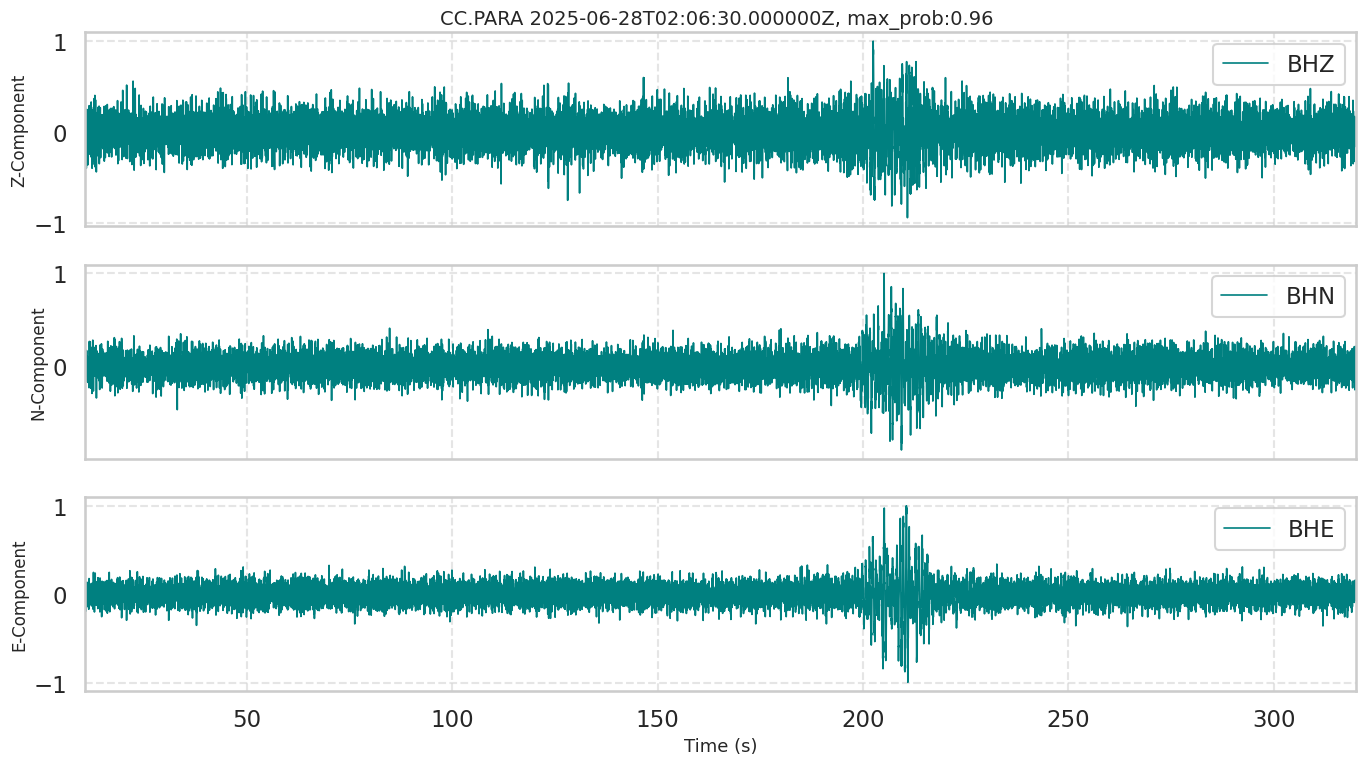

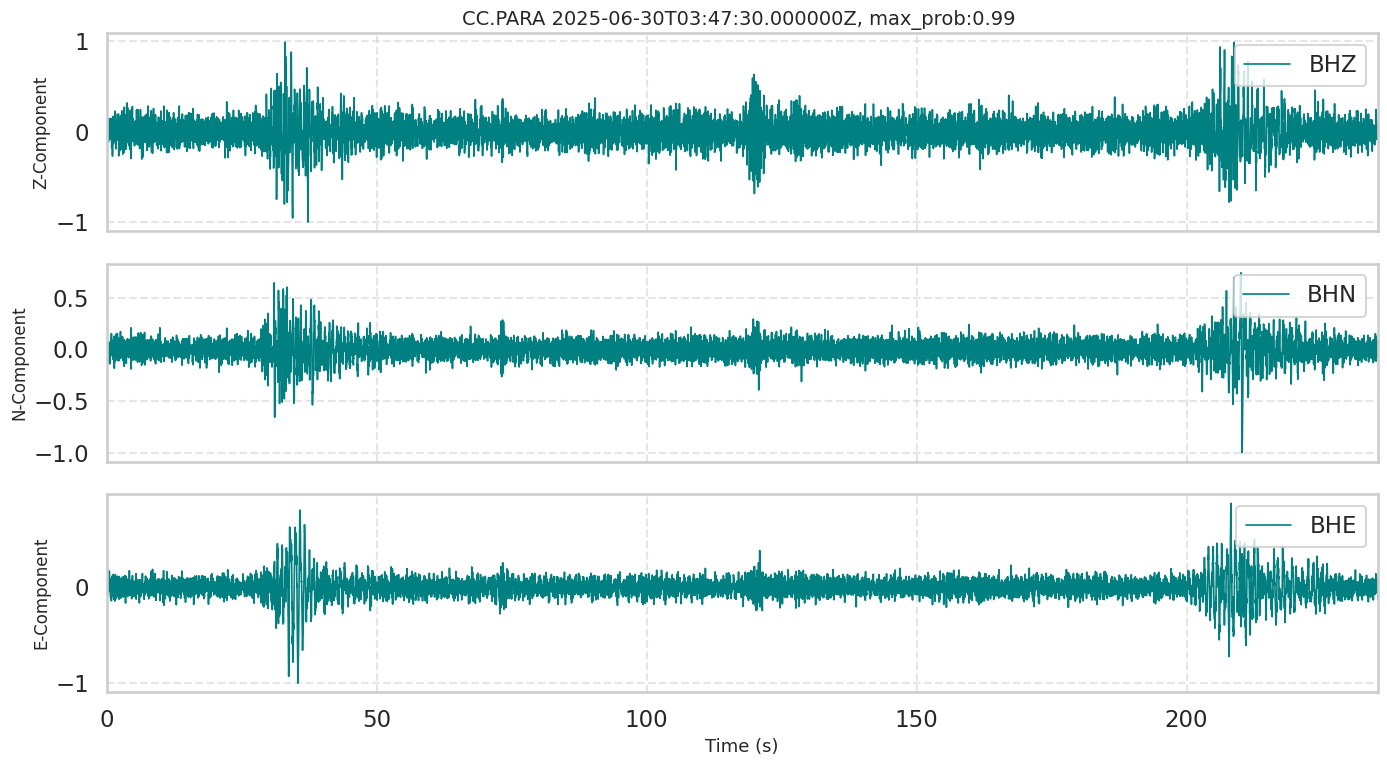

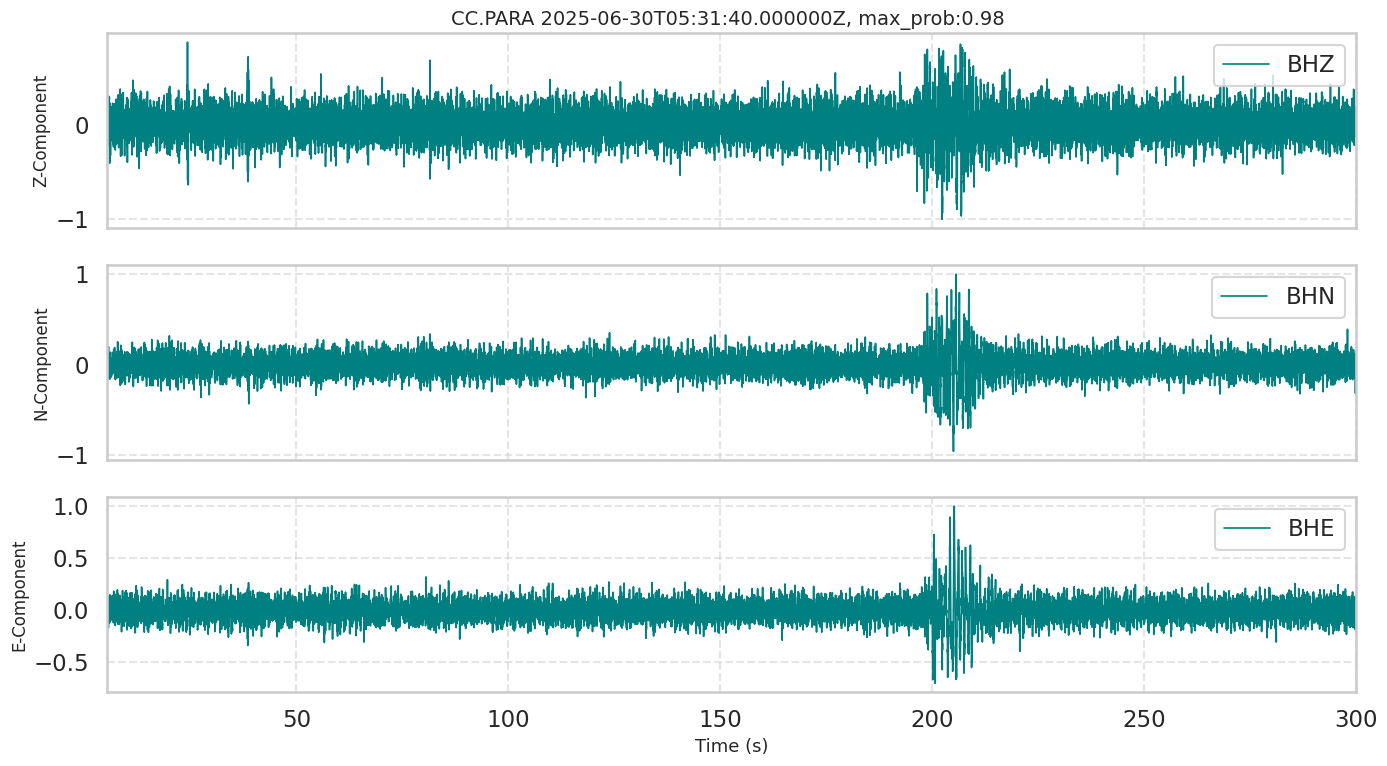

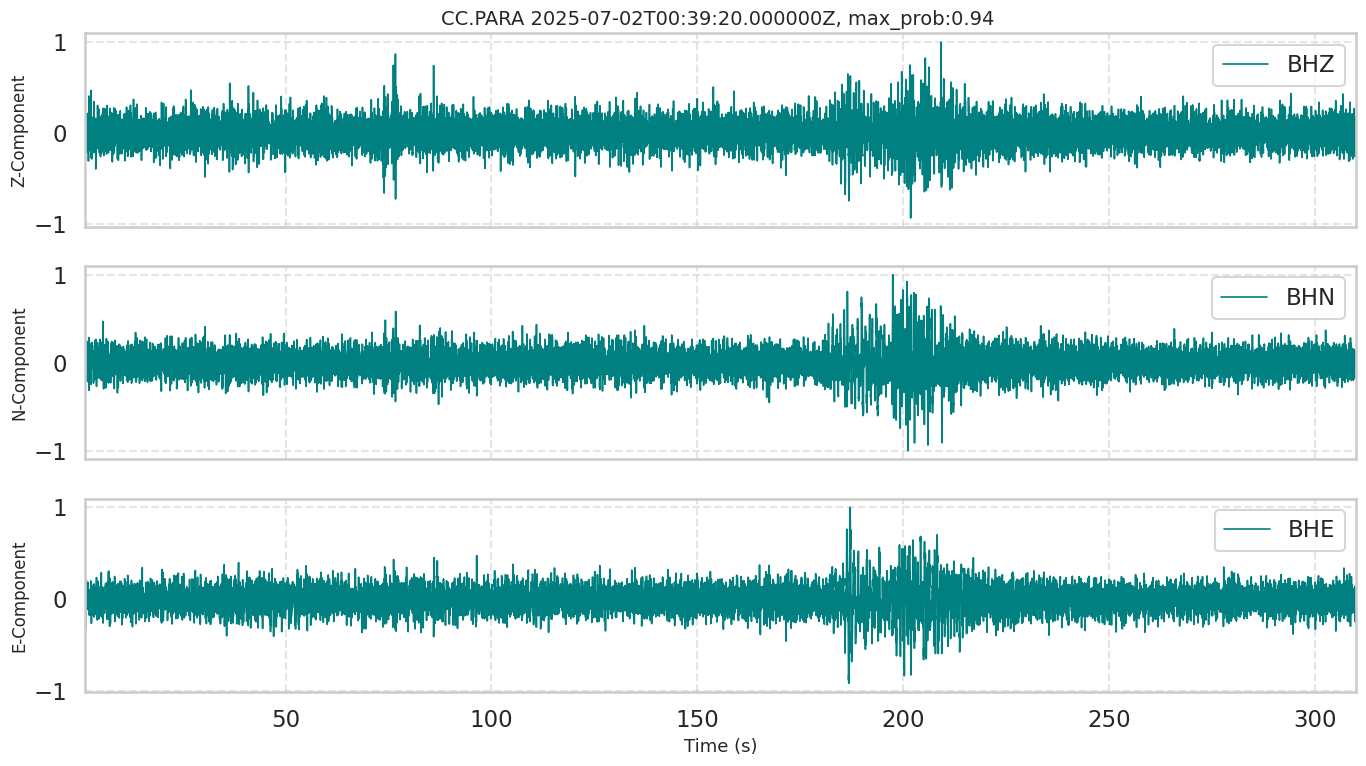

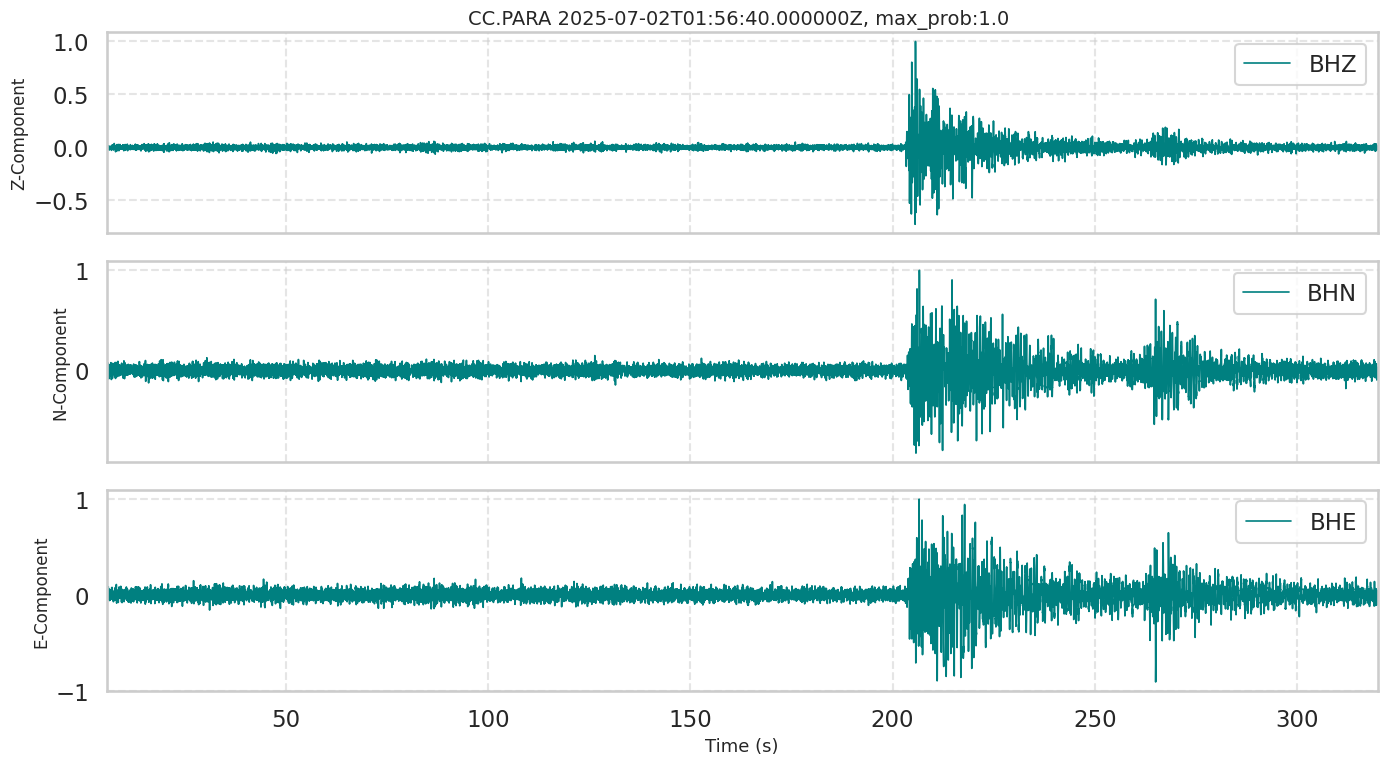

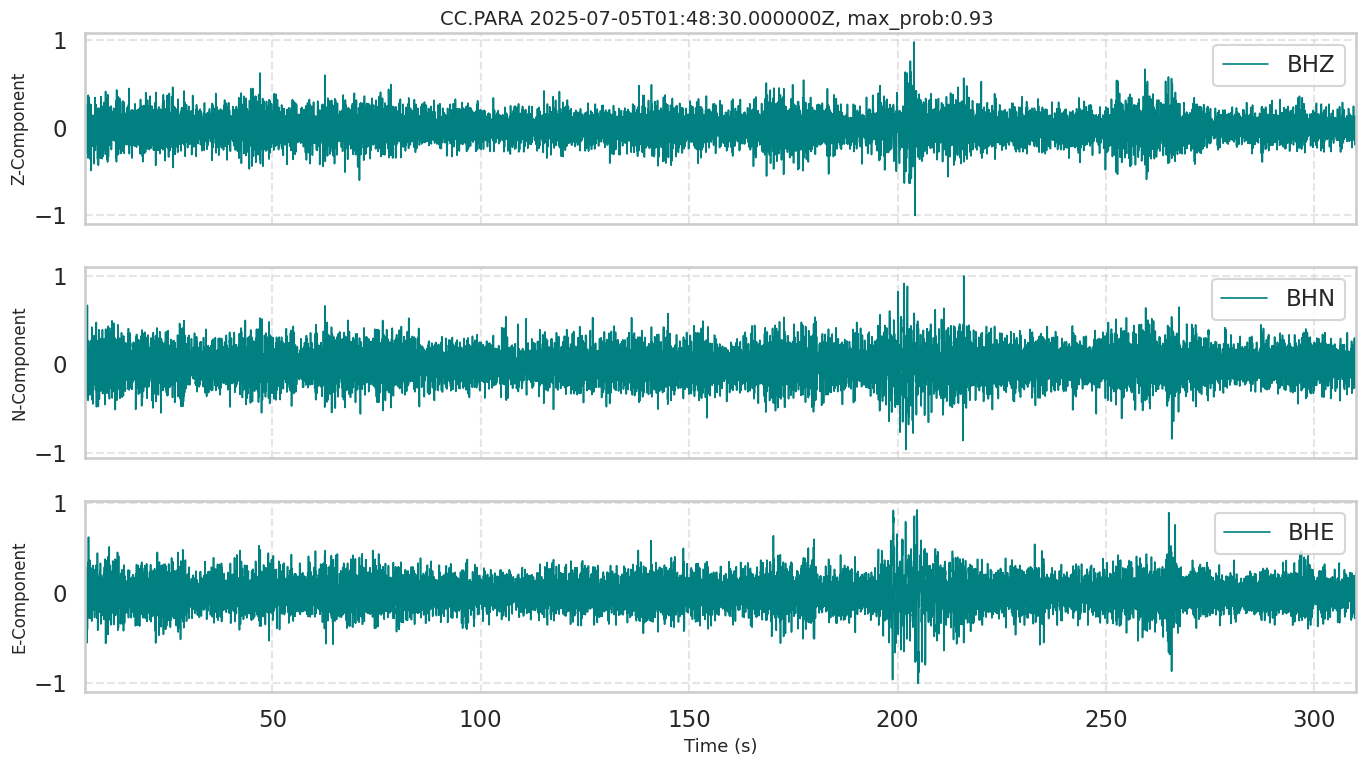

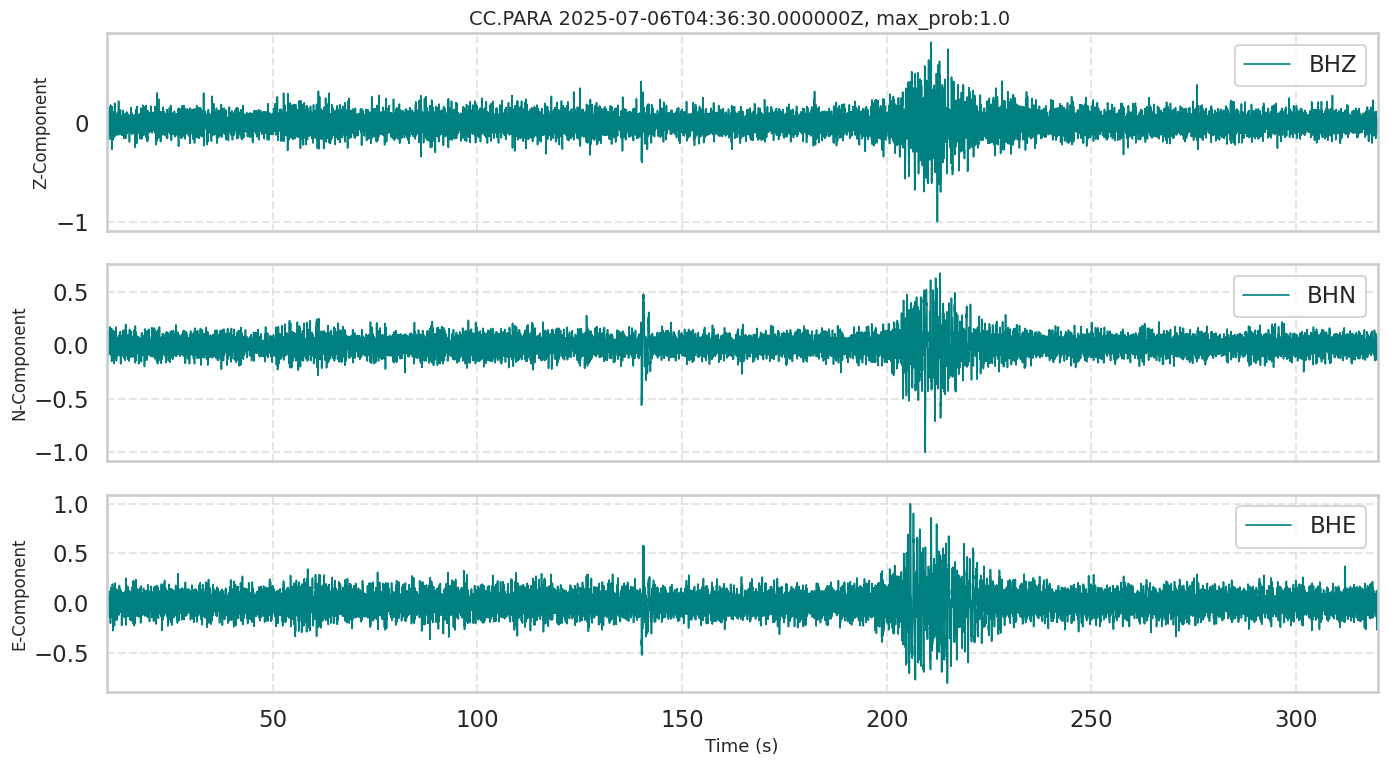

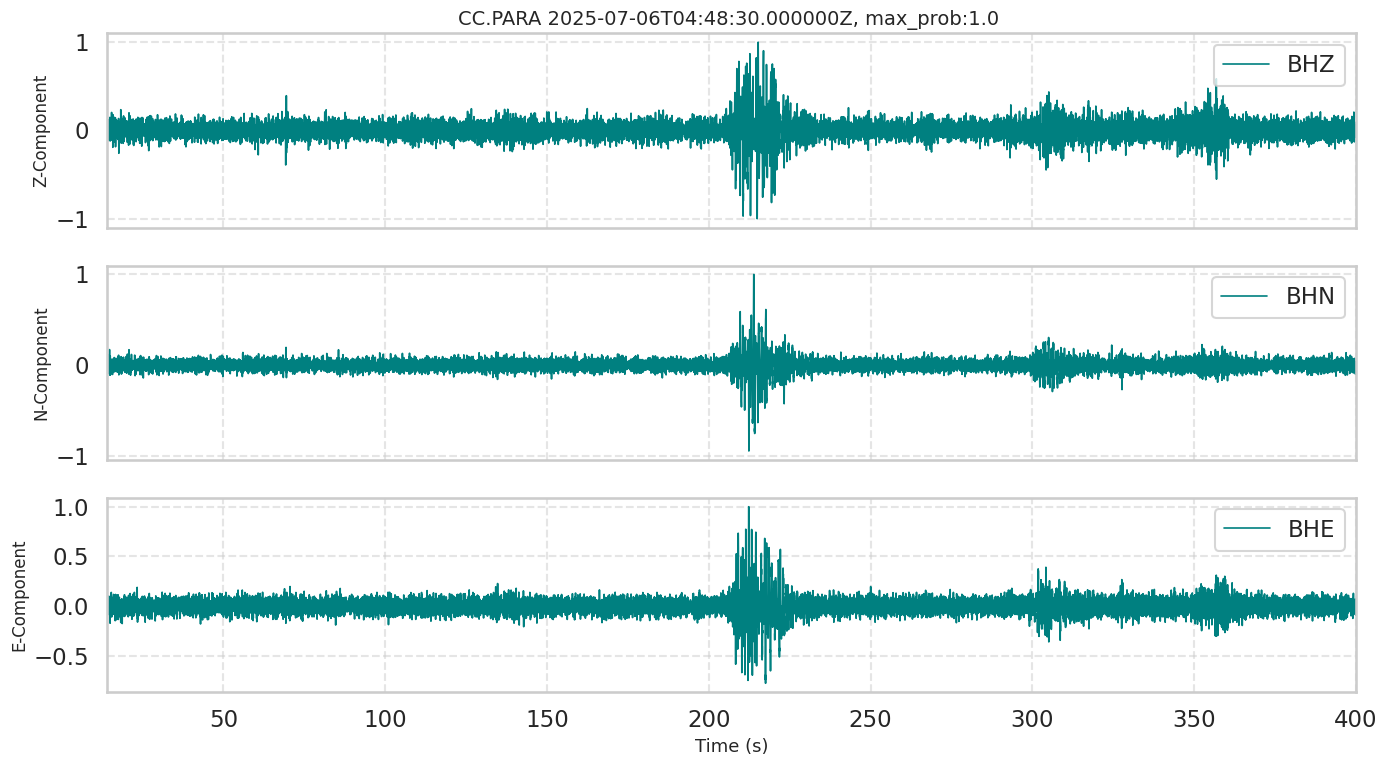

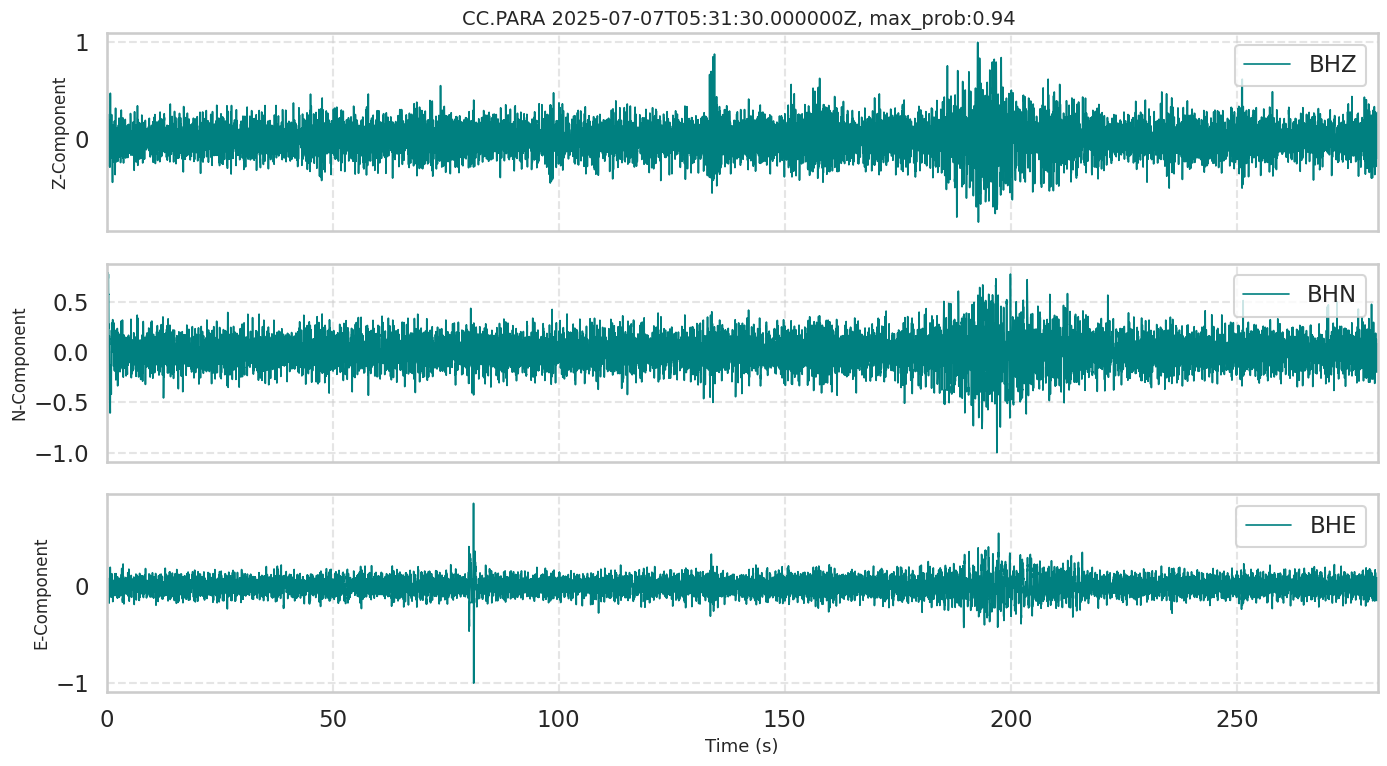

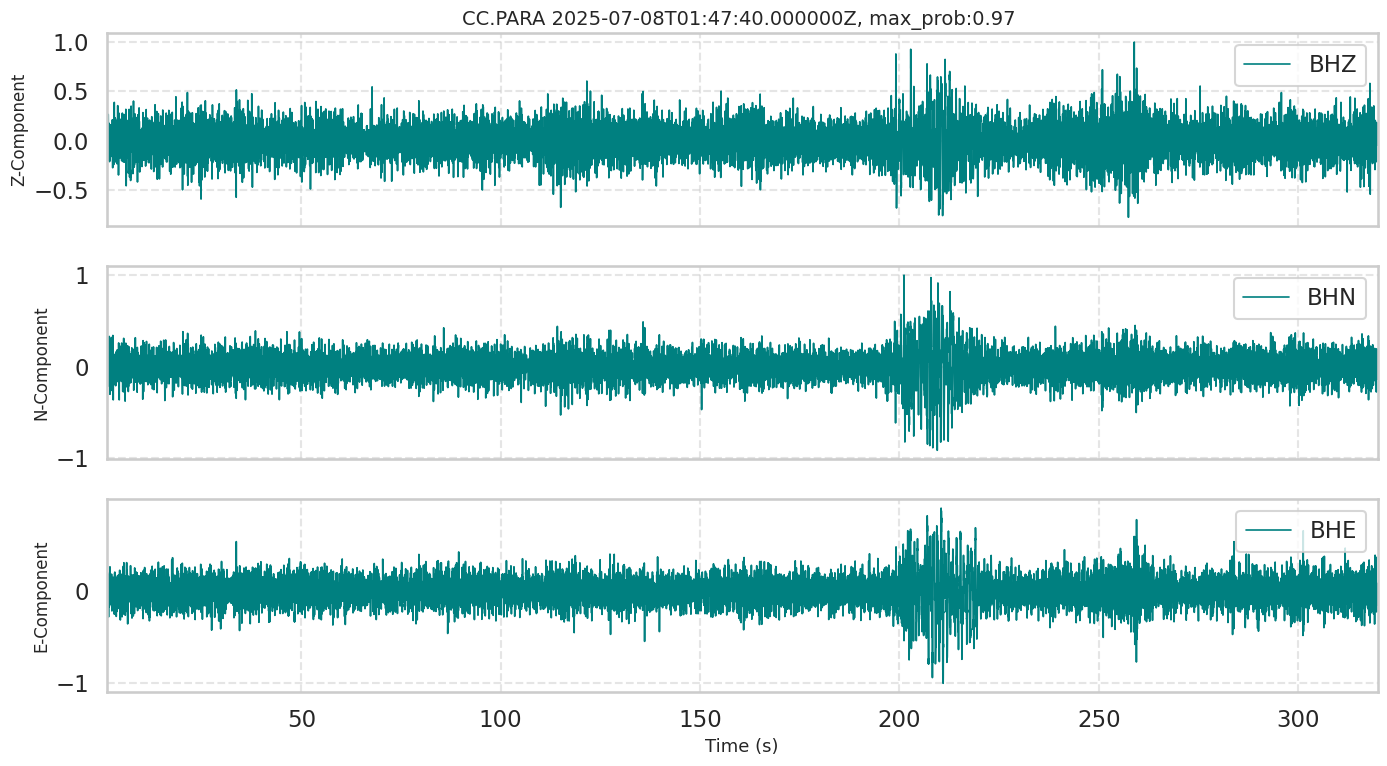

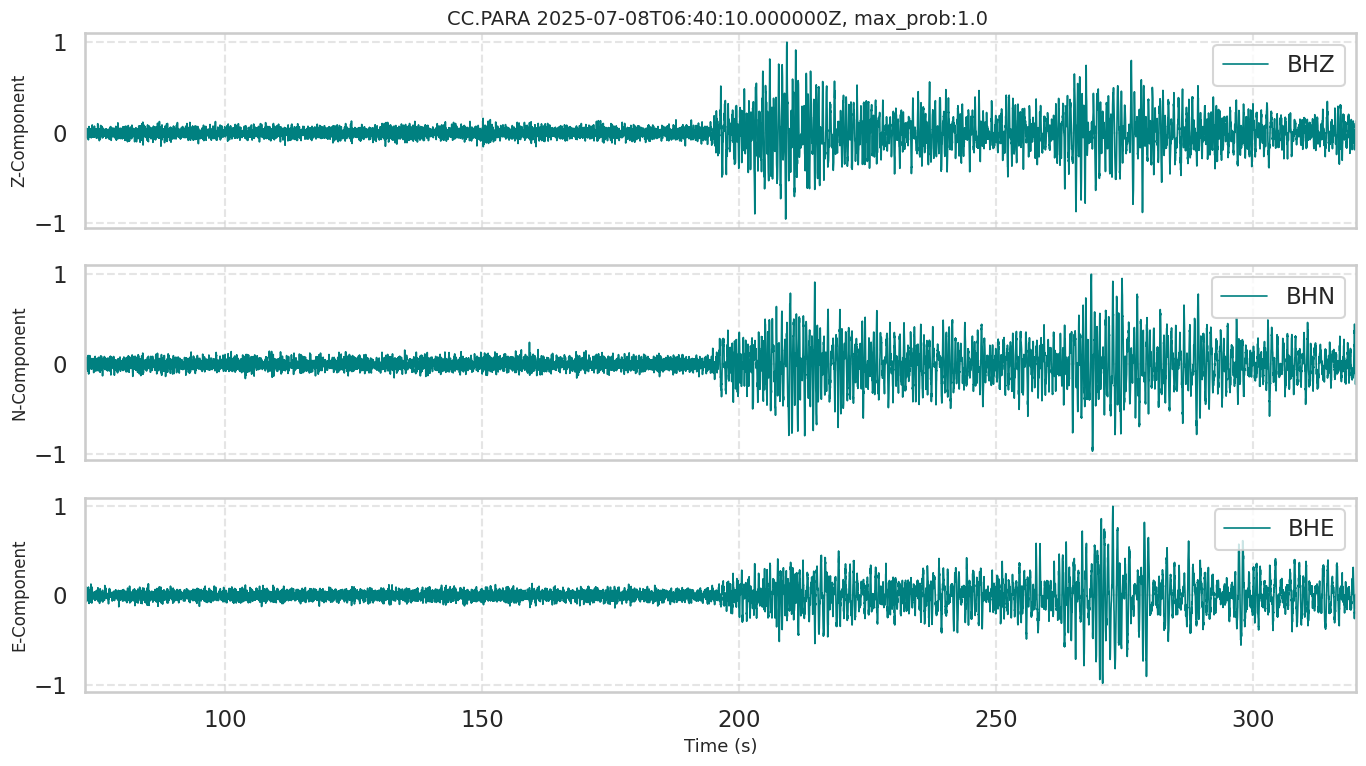

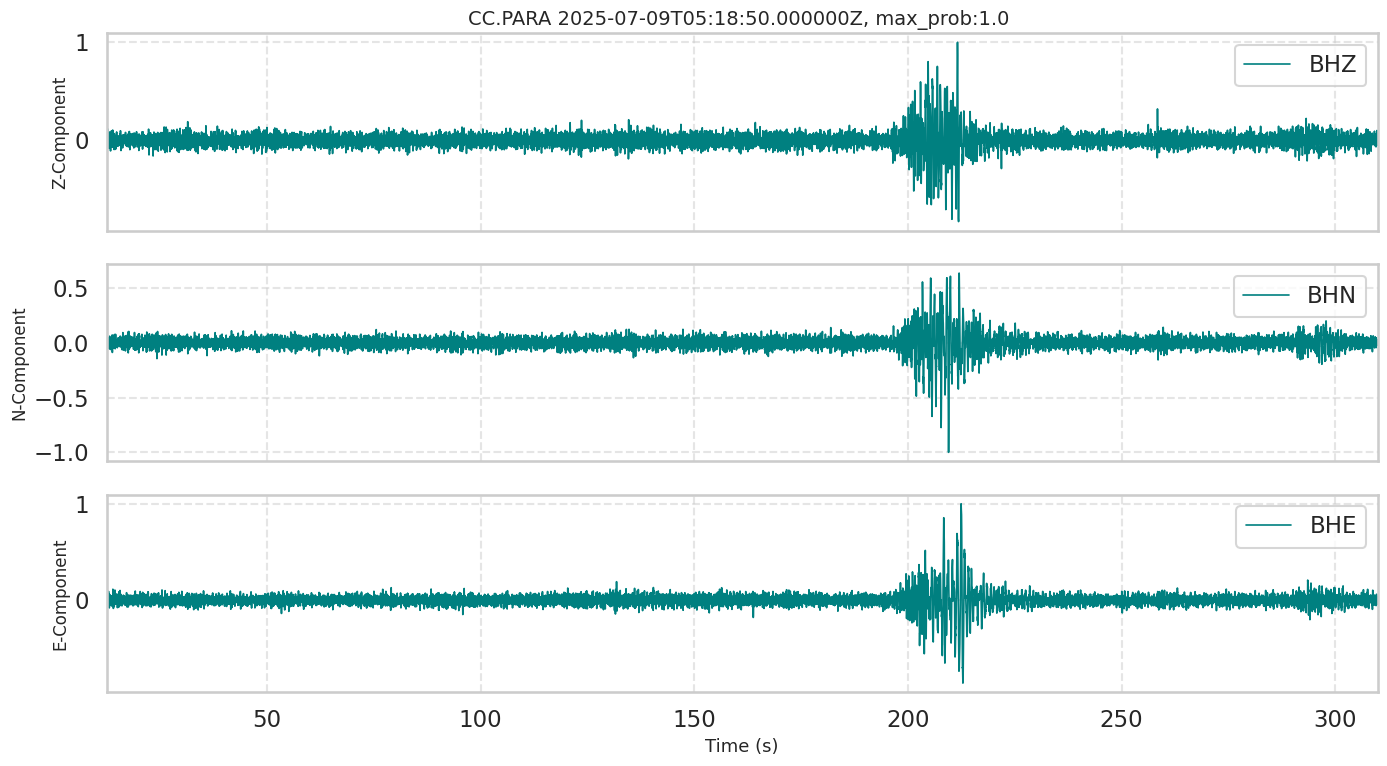

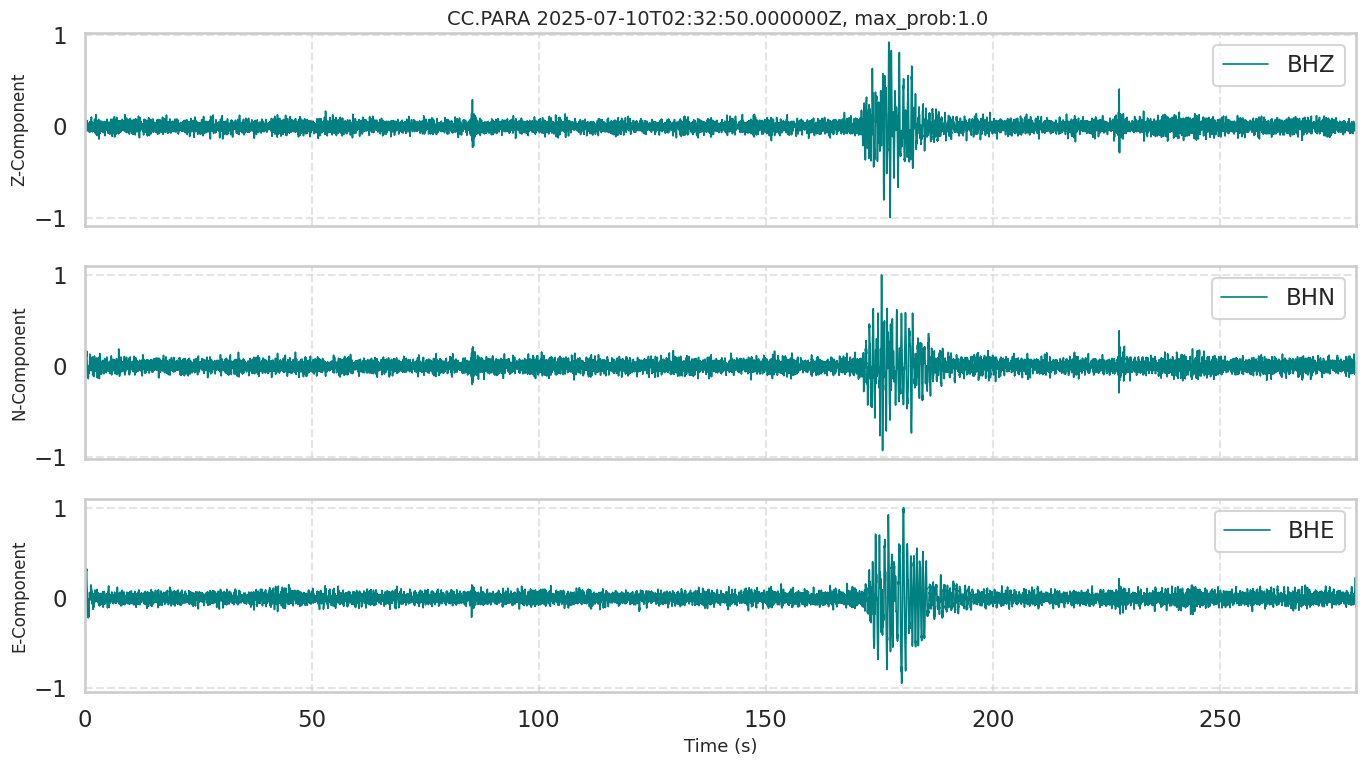

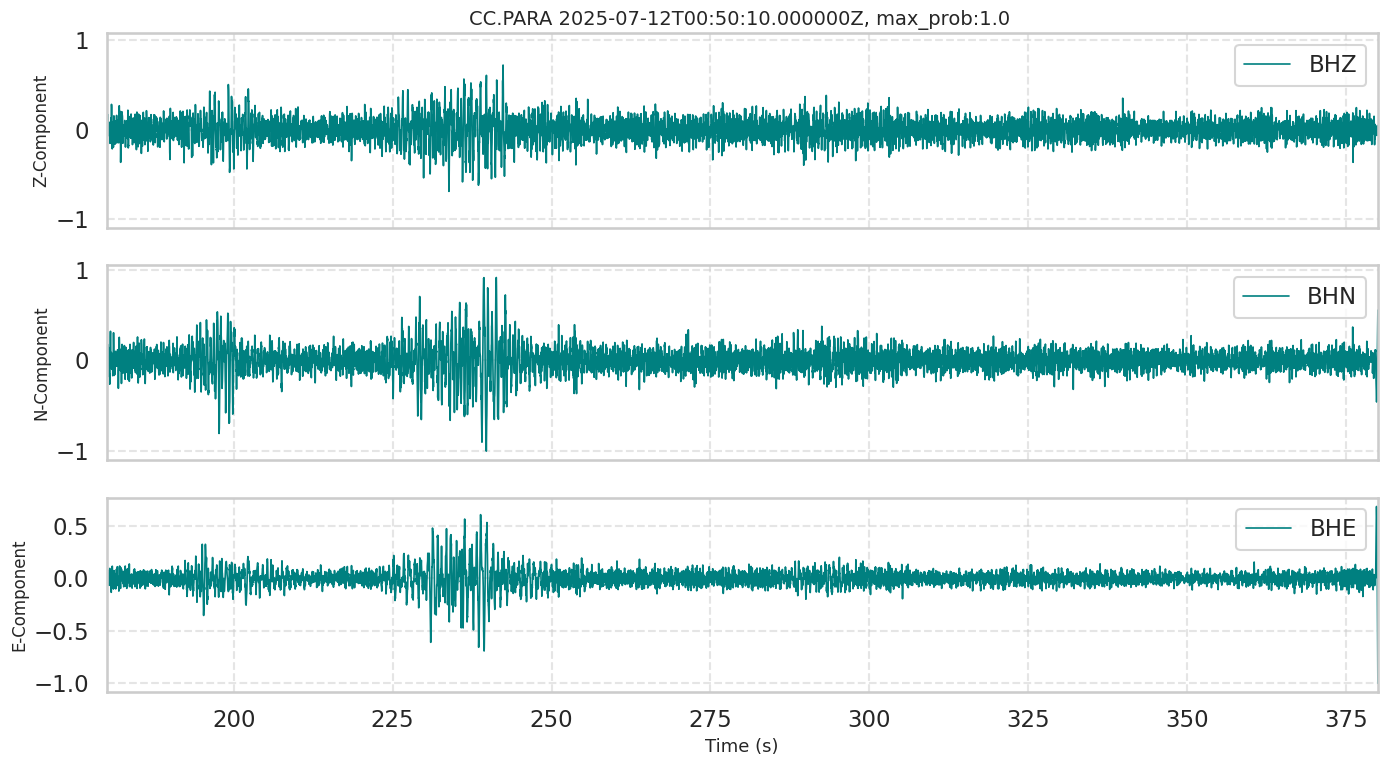

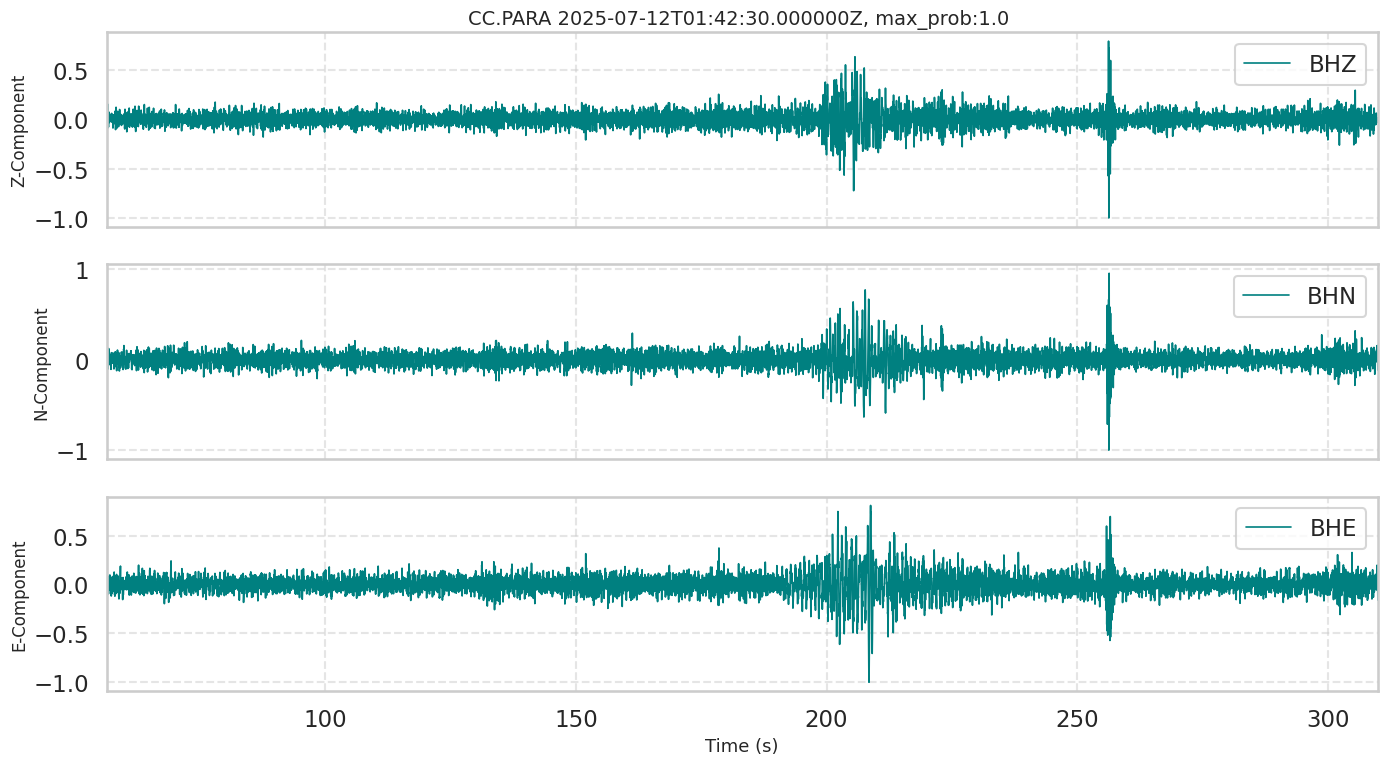

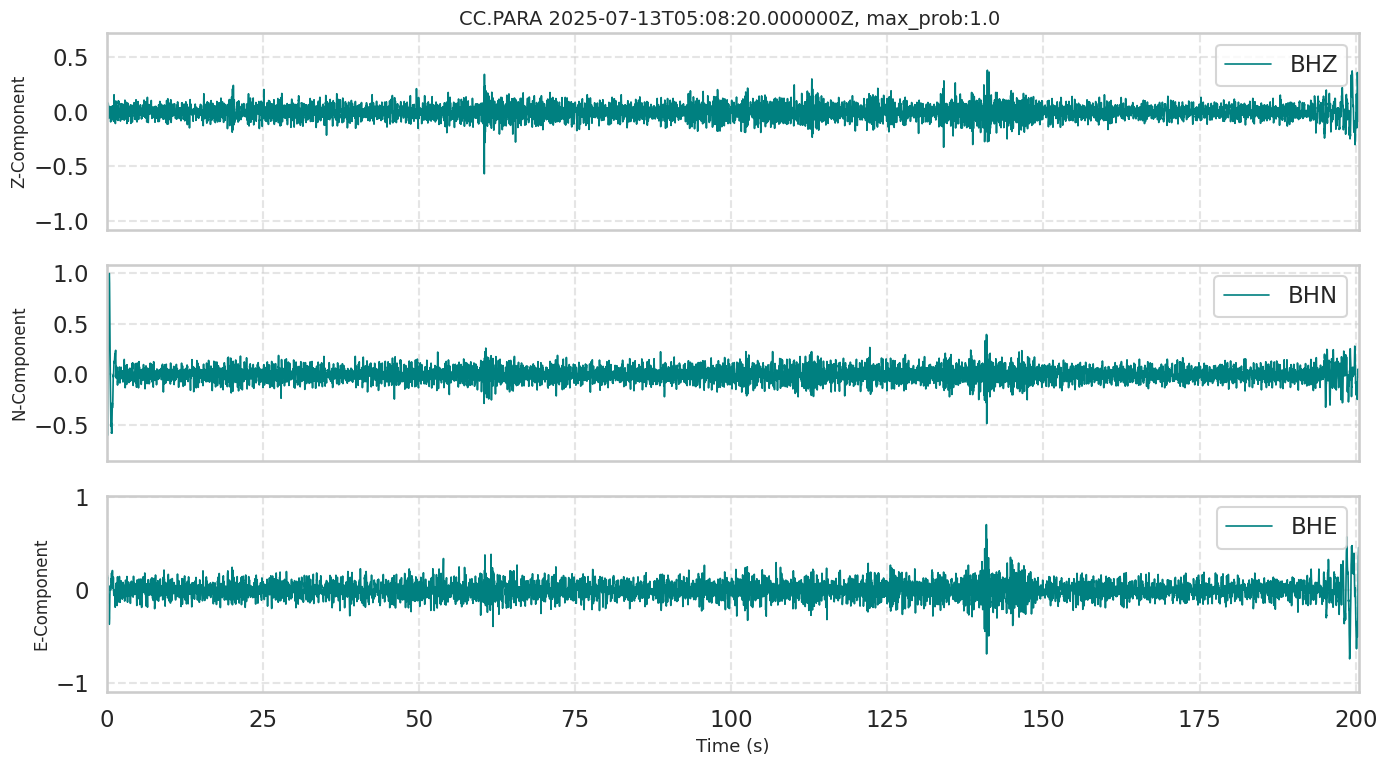

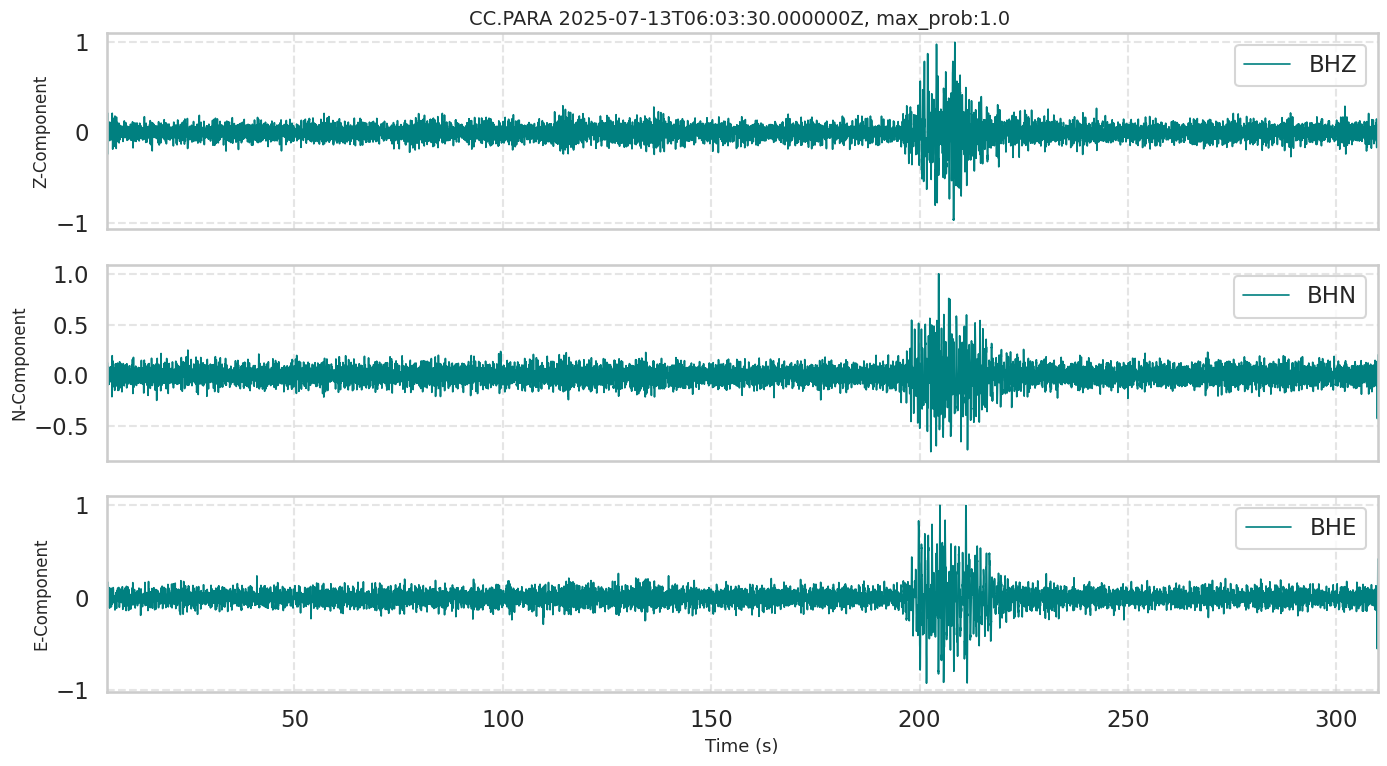

In [308]:
for i in range(len(high_conf_df)):

        network = 'CC'
        station = 'PARA'
        channel = '*H*'
        
        max_prob = np.around(high_conf_df['para_max_prob'].values[i],2)
        
        starttime = UTCDateTime(str(high_conf_df['starttime'].values[i])) - 100
        endtime = UTCDateTime(str(high_conf_df['endtime'].values[i])) +100

        # Get waveform and model probabilities
        st = client.get_waveforms(starttime=starttime, endtime=endtime,
                                  network=network, station=station,
                                  channel=channel, location=loc)


        st.detrend('linear')
        st.taper(0.001)
        st.filter('bandpass', freqmin = 1, freqmax = 20)






        st.merge(method=1)  # ensure a single continuous Trace per channel

        # Stack max amplitude time across all traces
        max_idx = np.argmax([np.max(np.abs(tr.data)) for tr in st])
        main_trace = st[np.argmax([np.max(np.abs(tr.data)) for tr in st])]
        peak_time = main_trace.times()[np.argmax(np.abs(main_trace.data))]

        # Set time window ±200s around peak
        x_min = max(0, peak_time - 200)
        x_max = min(main_trace.times()[-1], peak_time + 200)

        # Plot
        fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
        component_order = ['Z', 'N', 'E']

        for i, comp in enumerate(component_order):
            tr = [t for t in st if t.stats.channel[-1] == comp]
            if tr:
                tr = tr[0]
                t = tr.times()
                d = tr.data / np.max(np.abs(tr.data))  # normalize
                axs[i].plot(t, d, lw=1.2, label=f"{tr.stats.channel}", color="teal")
                axs[i].set_ylabel(f"{comp}-Component", fontsize=12)
                axs[i].grid(True, linestyle='--', alpha=0.5)
                axs[i].legend(loc="upper right")
            else:
                axs[i].set_visible(False)

        axs[2].set_xlabel("Time (s)", fontsize=13)
        axs[0].set_title(f"{network}.{station} {main_trace.stats.starttime}, max_prob:{max_prob} ", fontsize=14)
        plt.xlim(x_min, x_max)
        plt.tight_layout()
        plt.show()


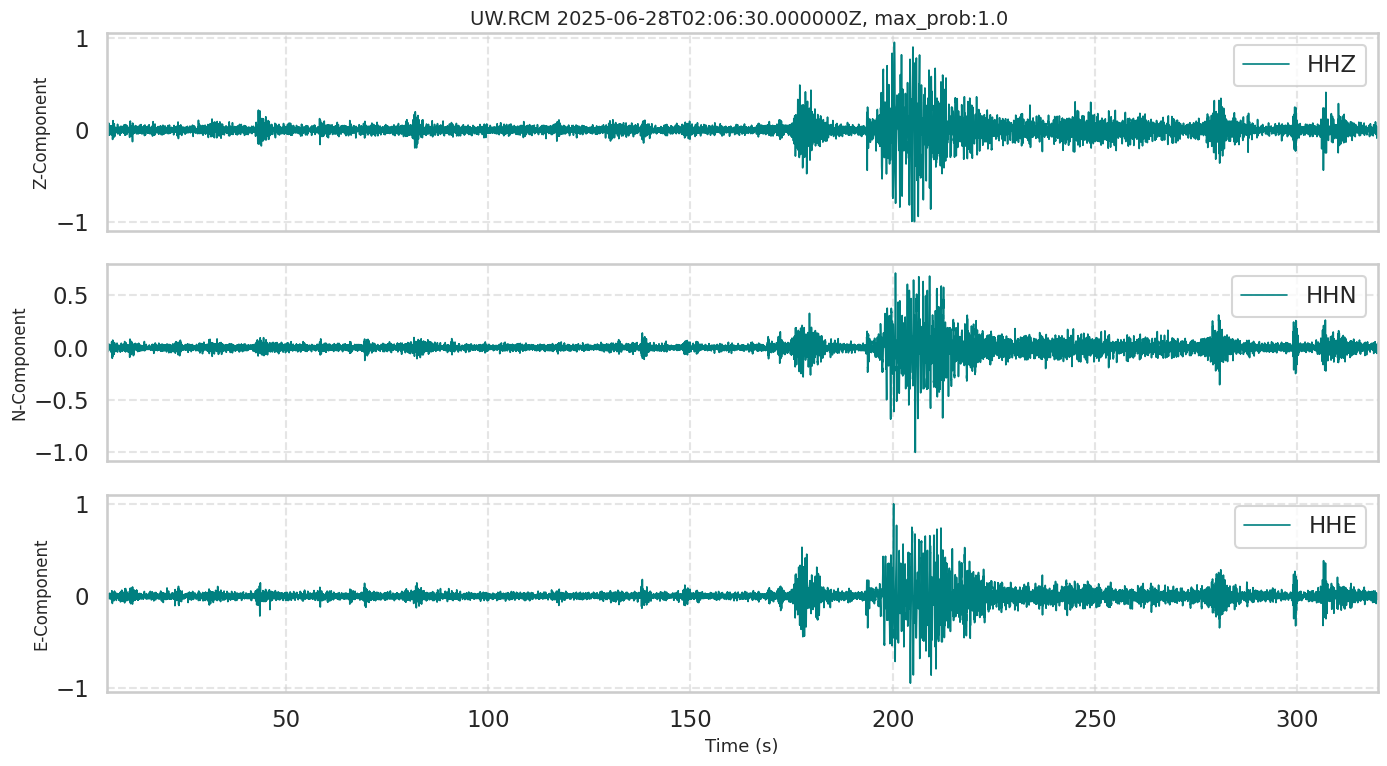

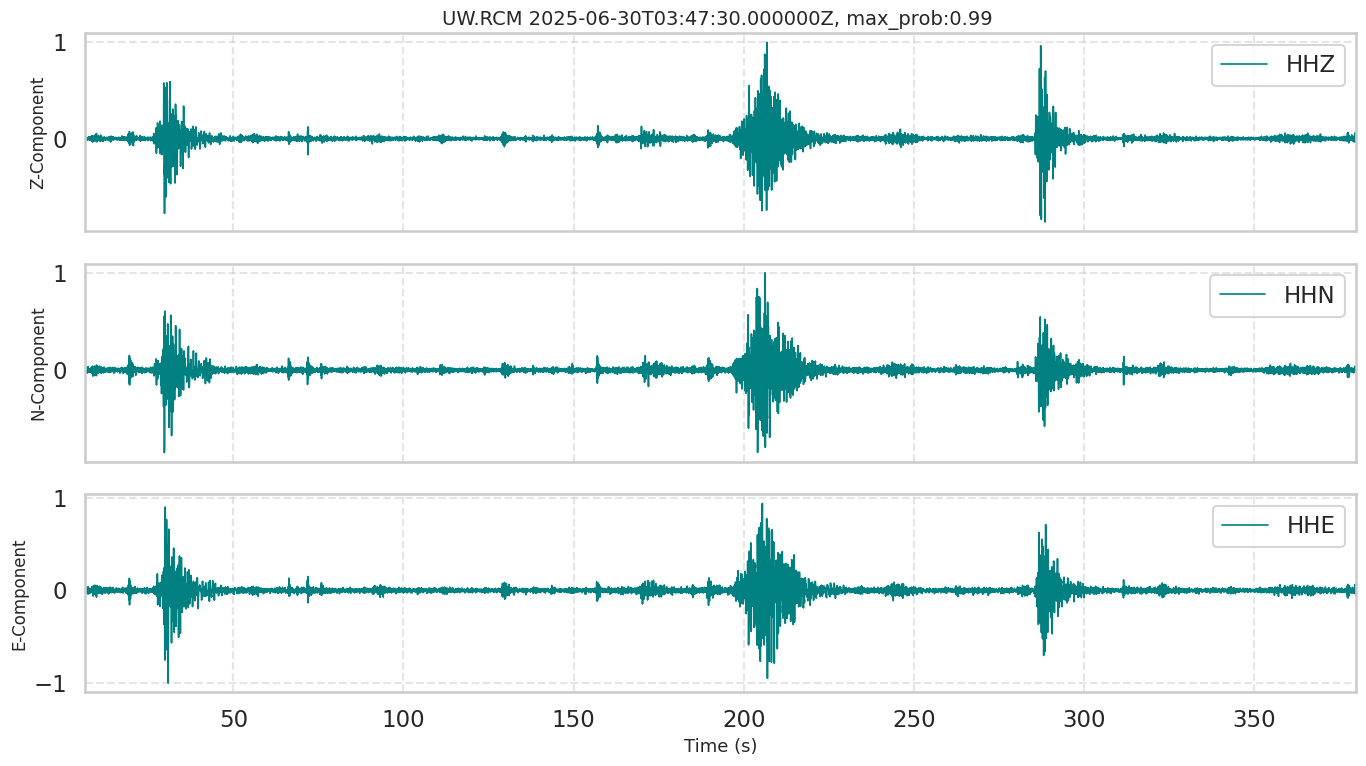

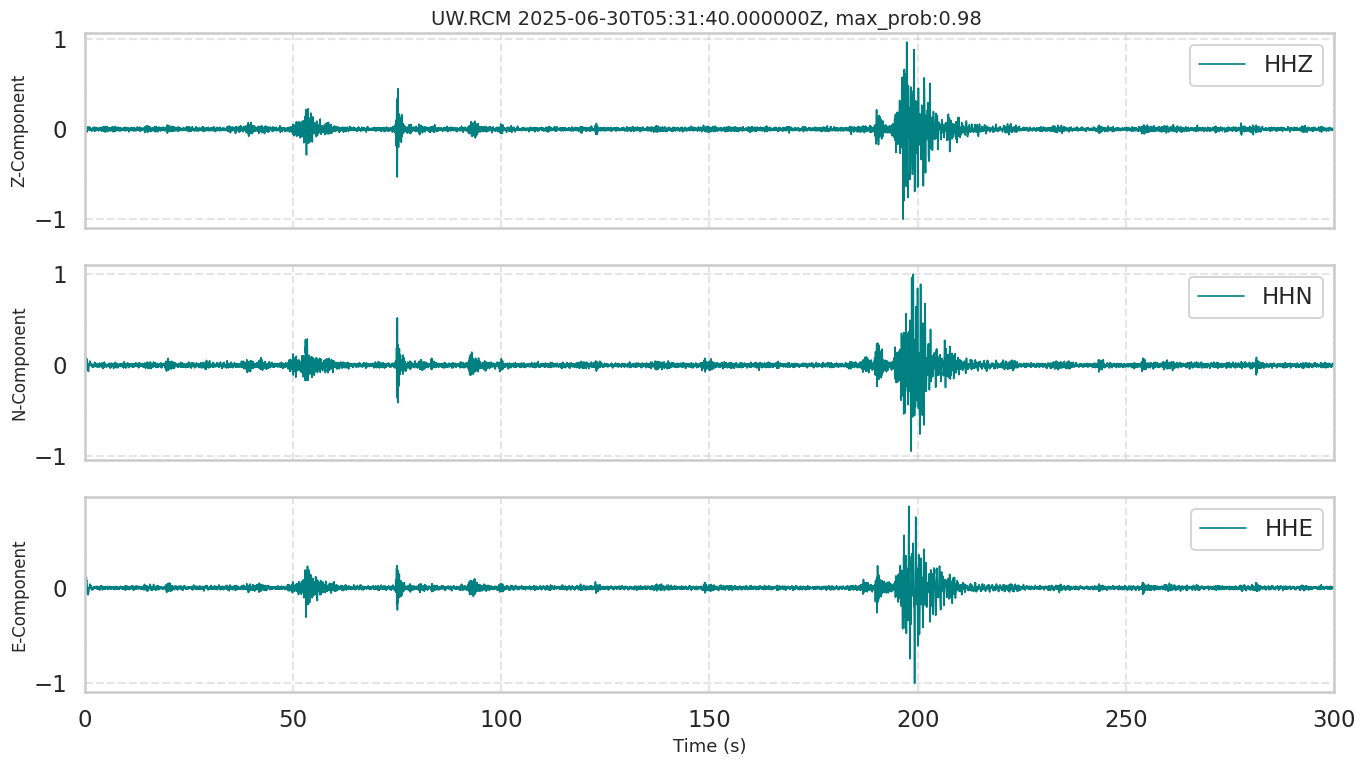

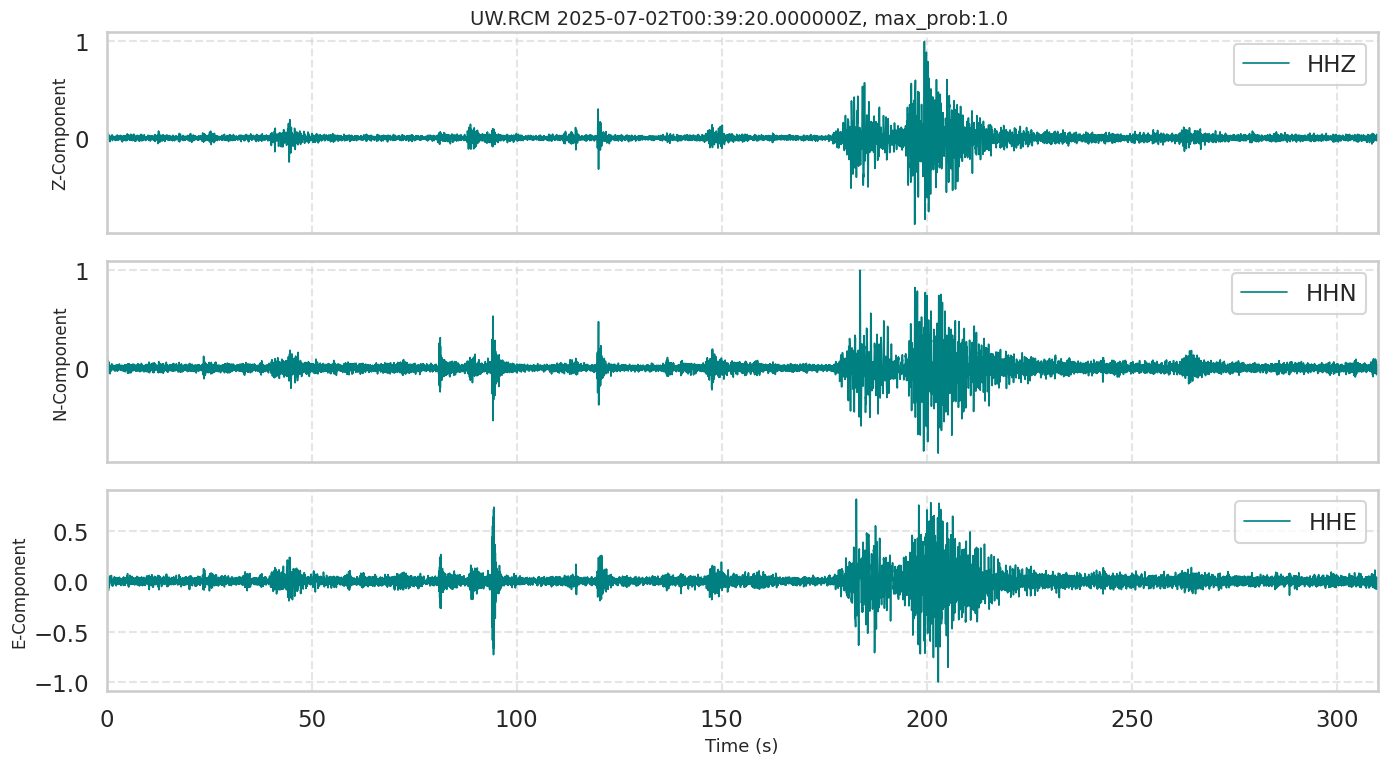

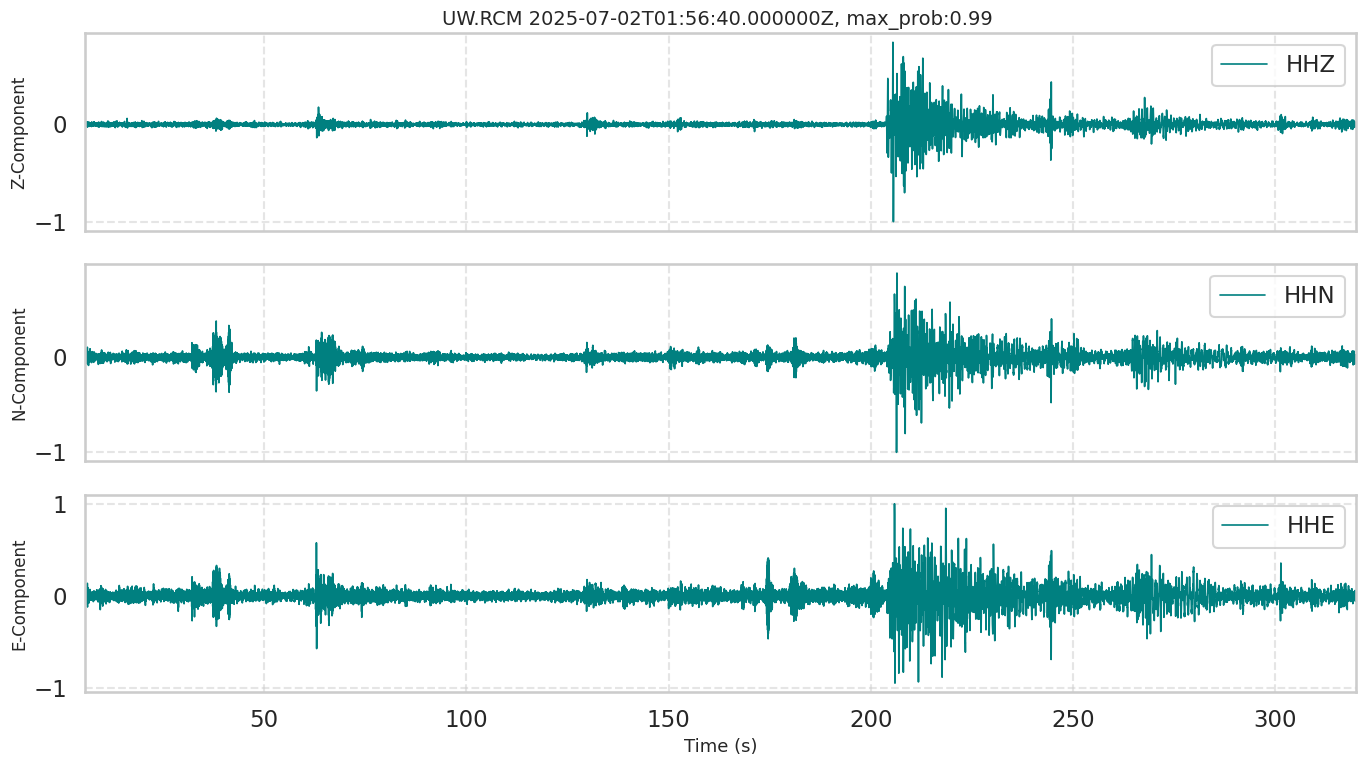

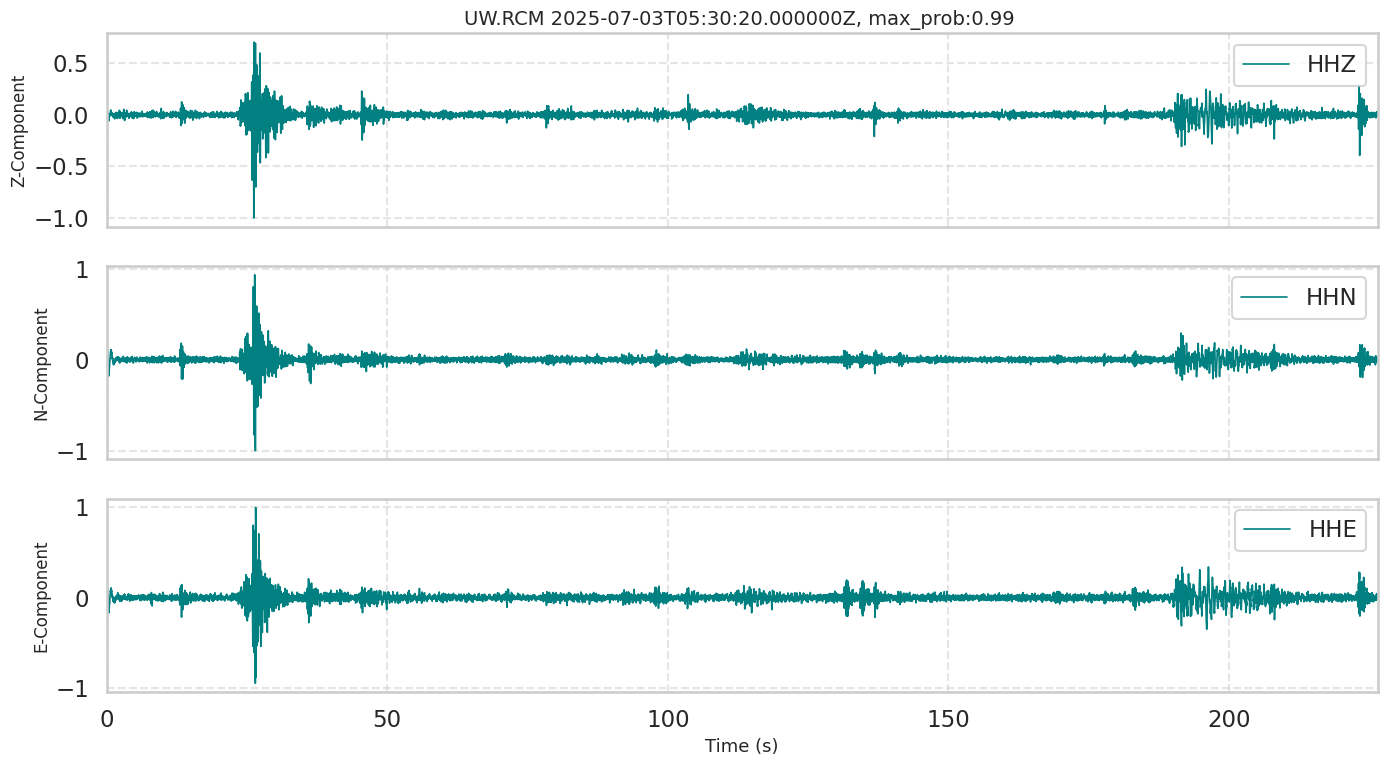

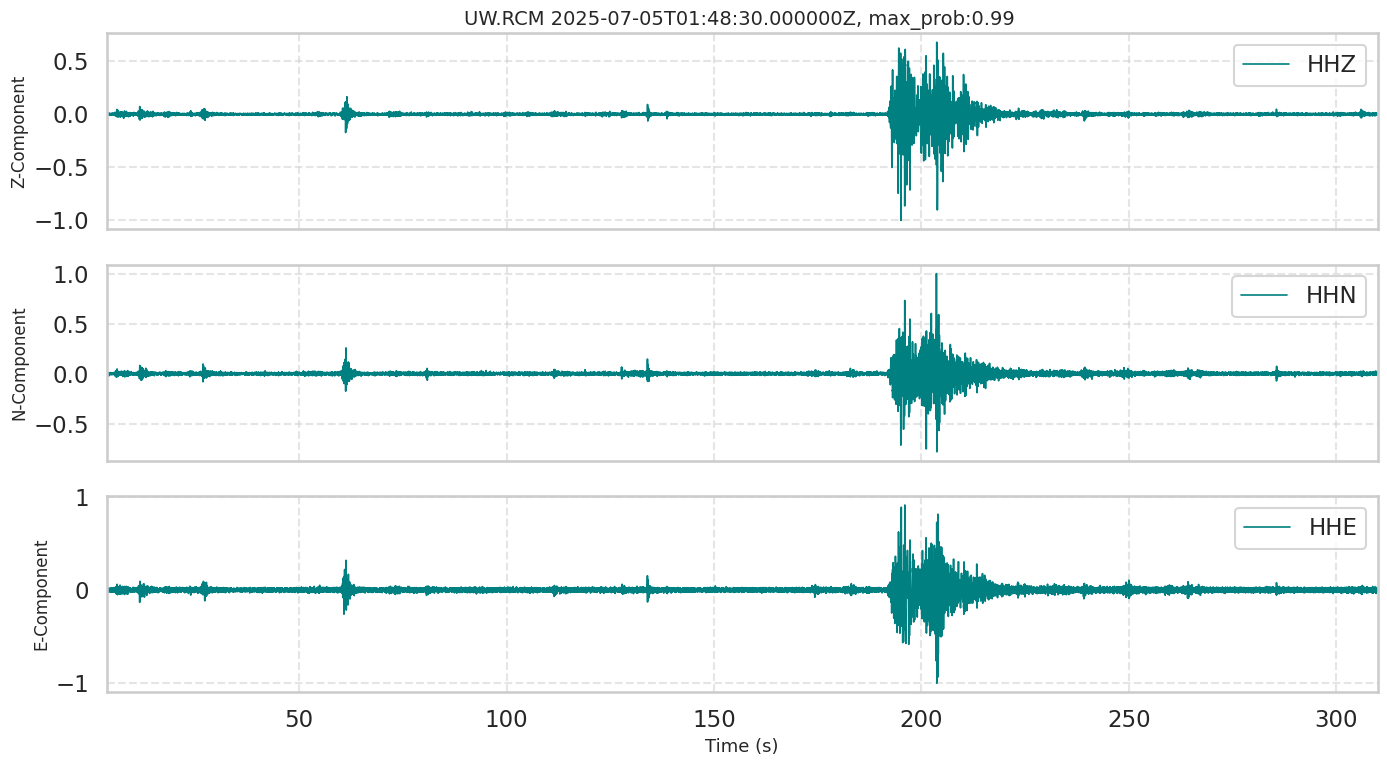

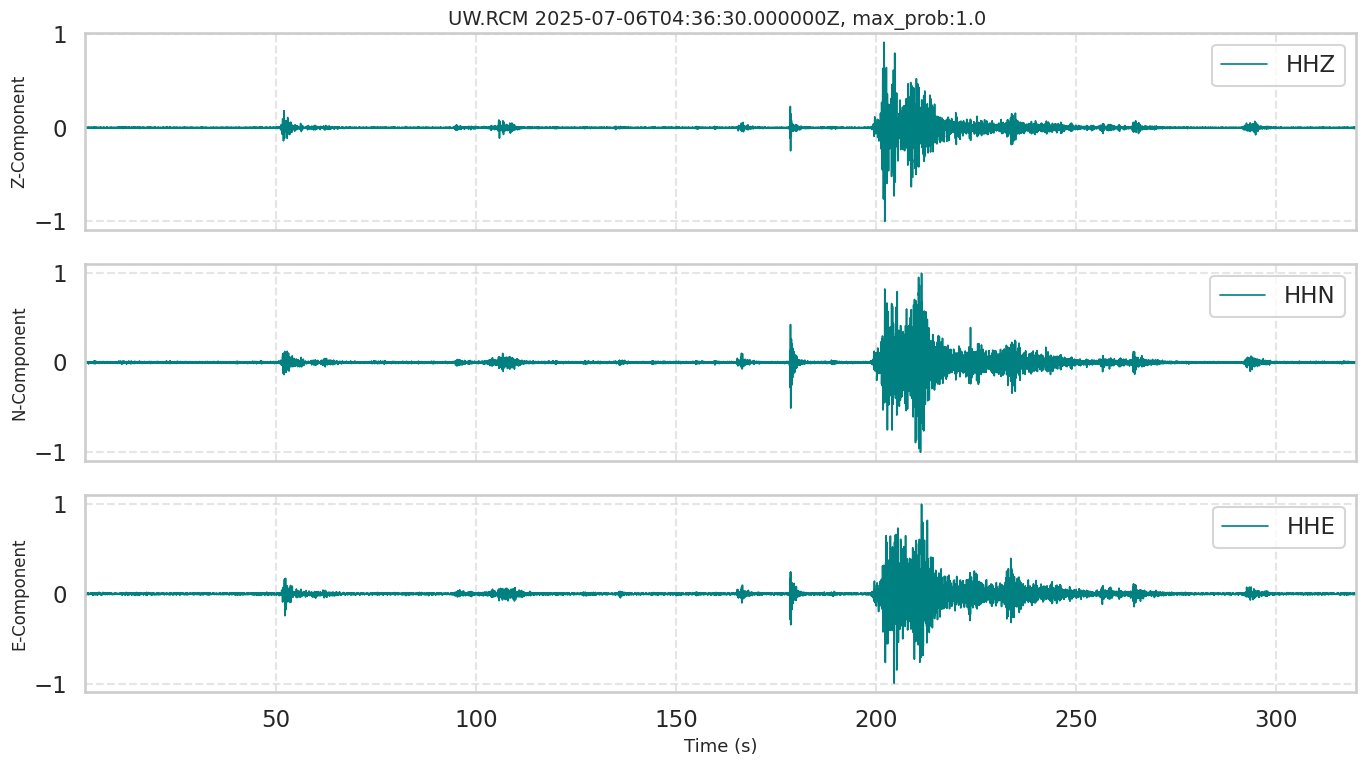

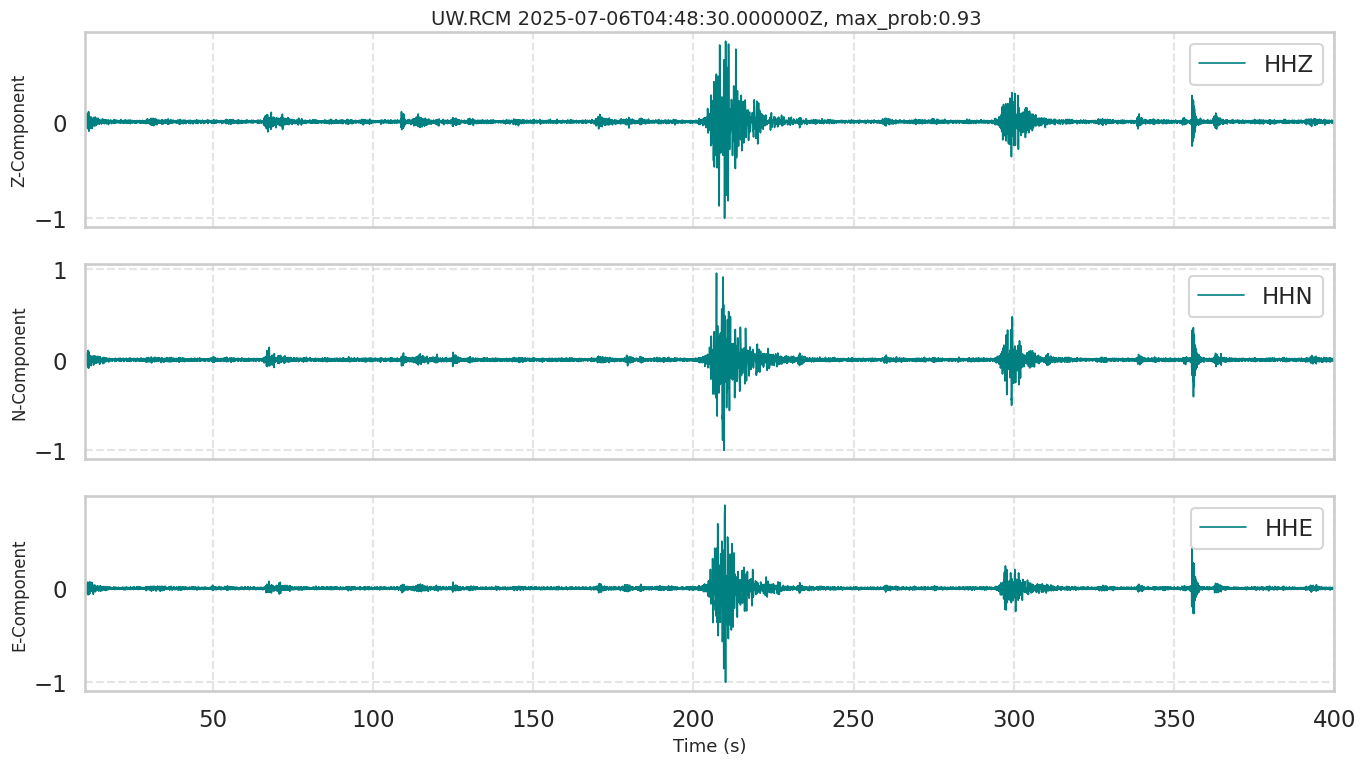

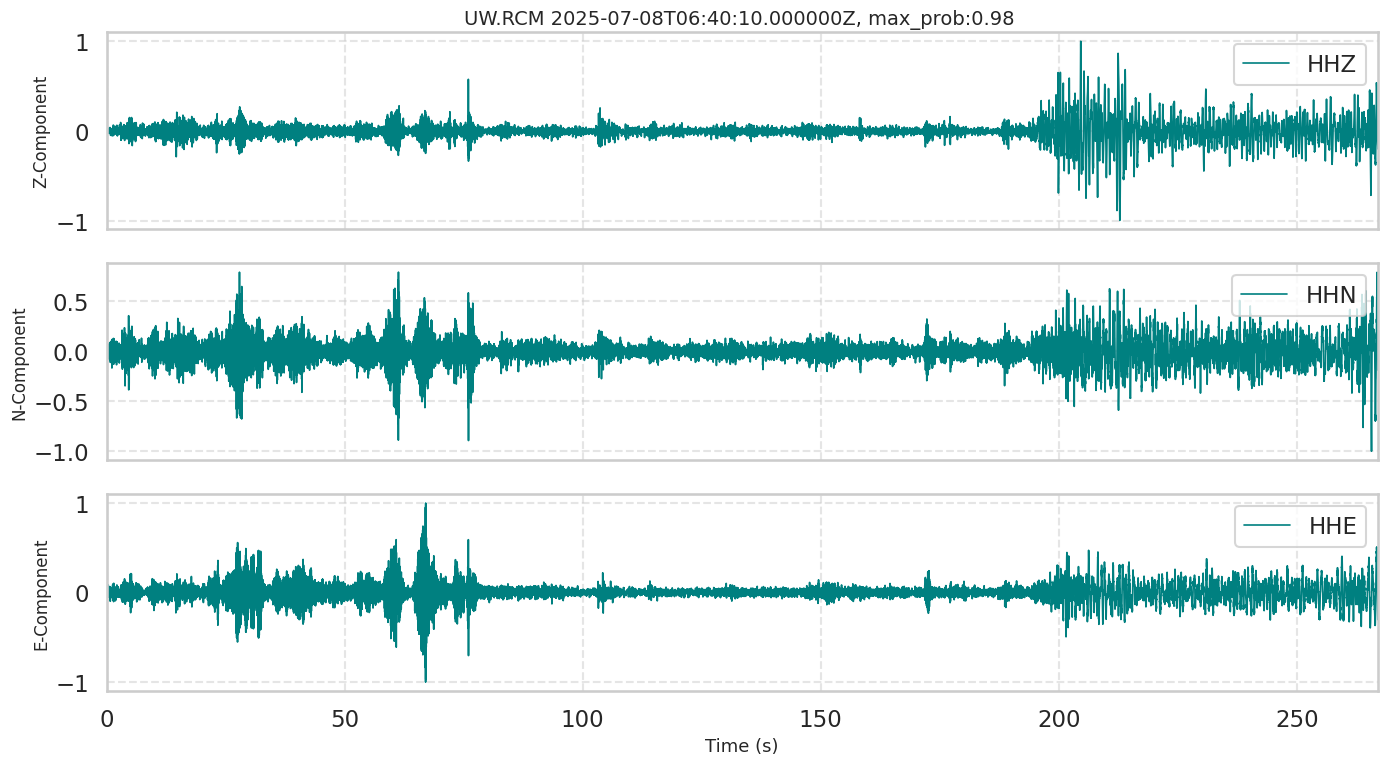

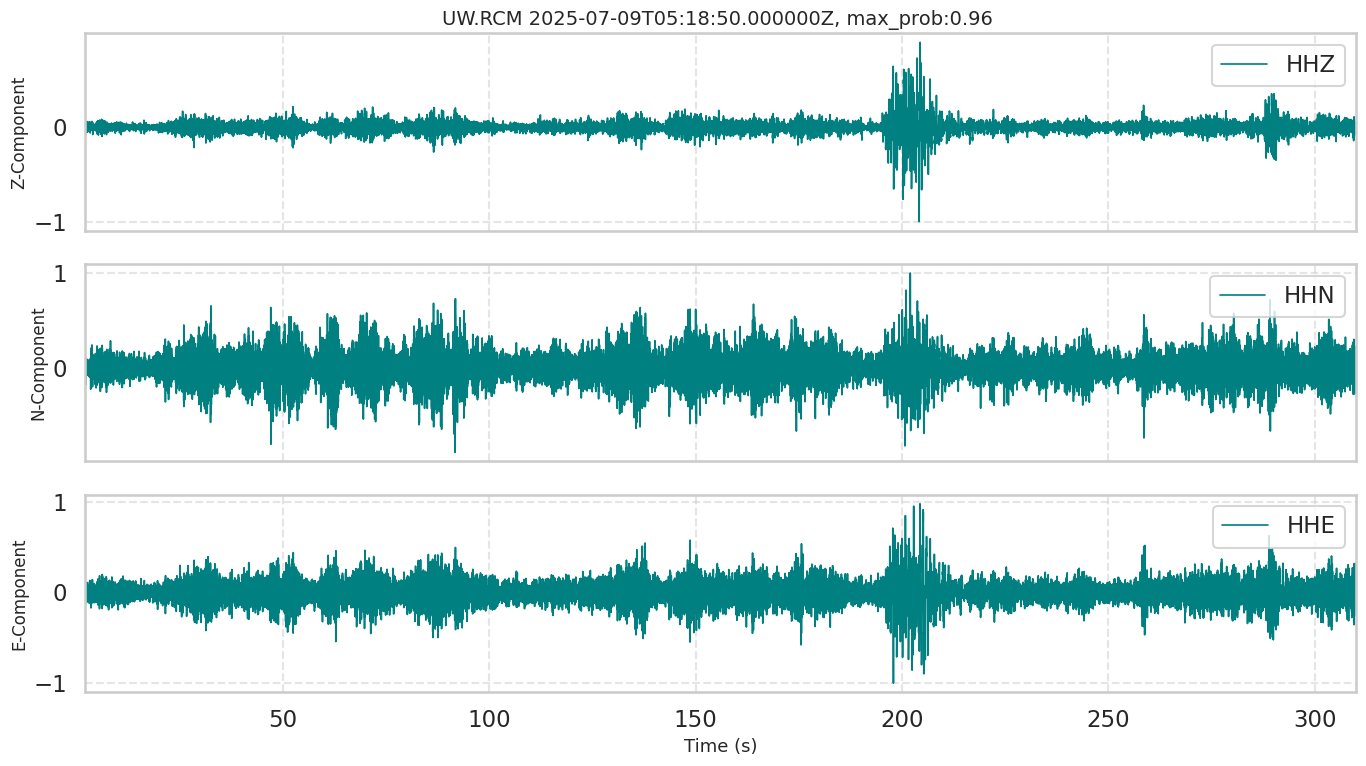

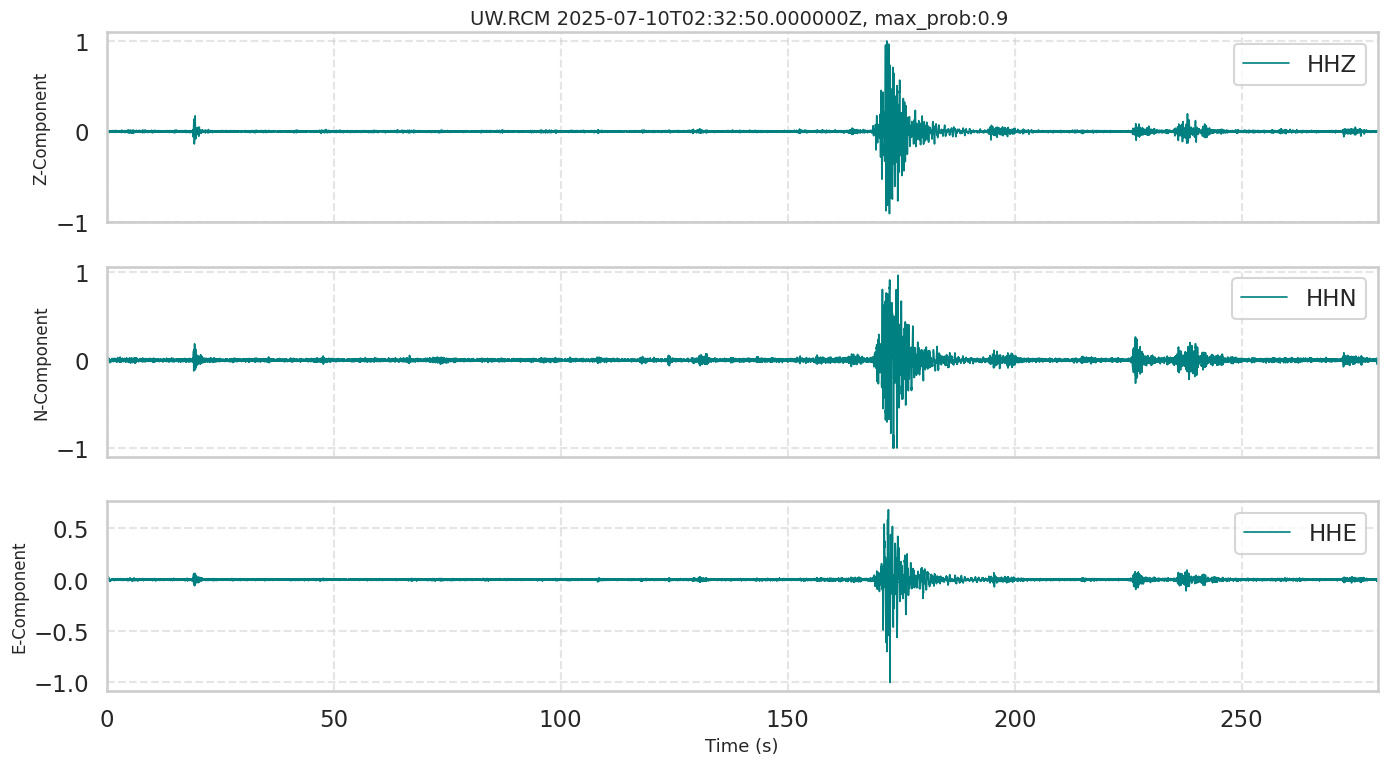

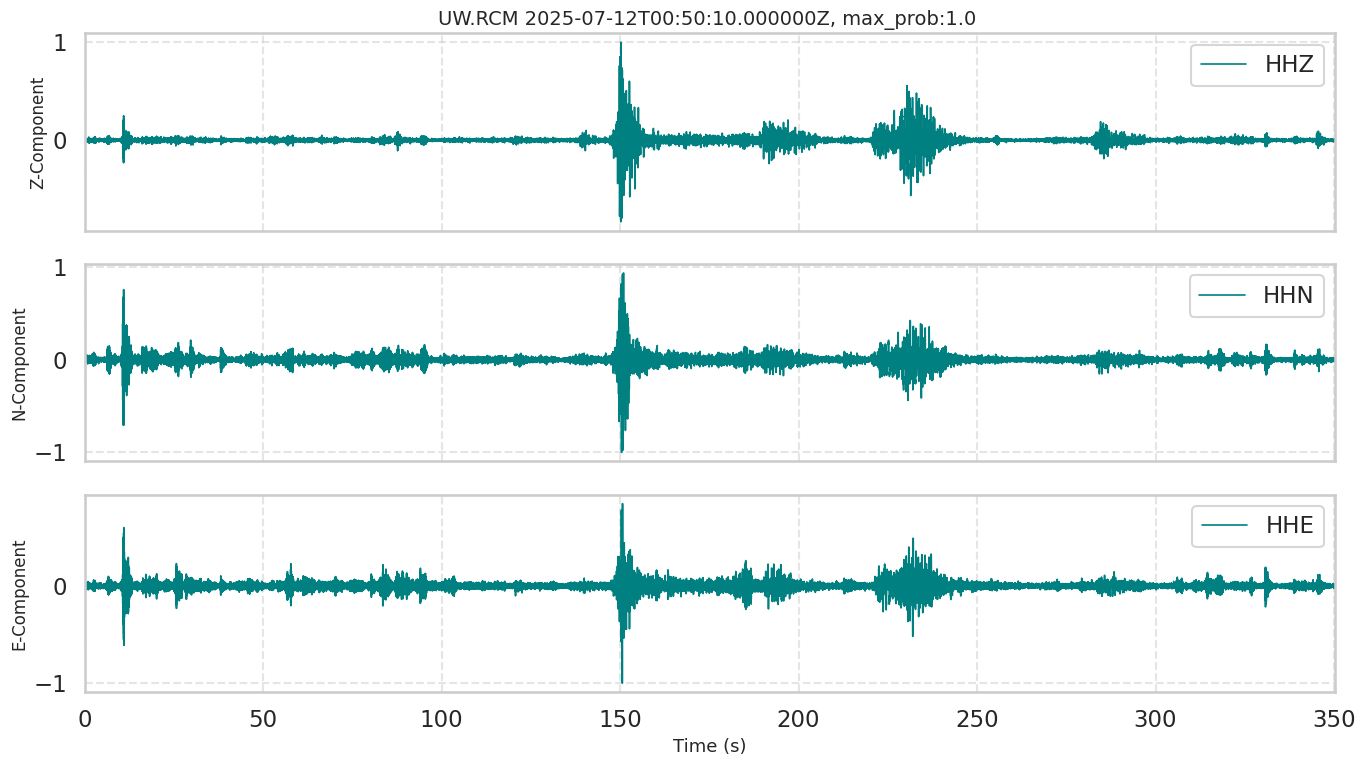

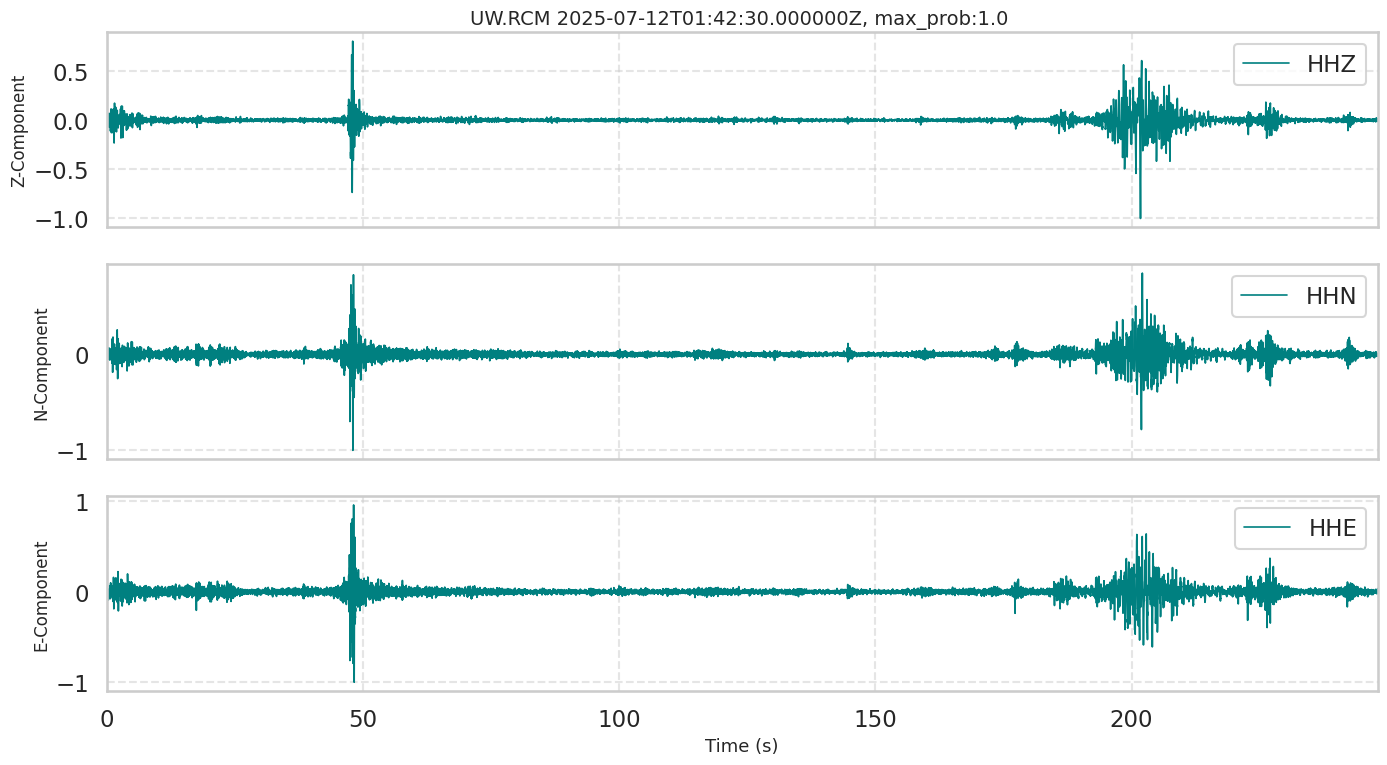

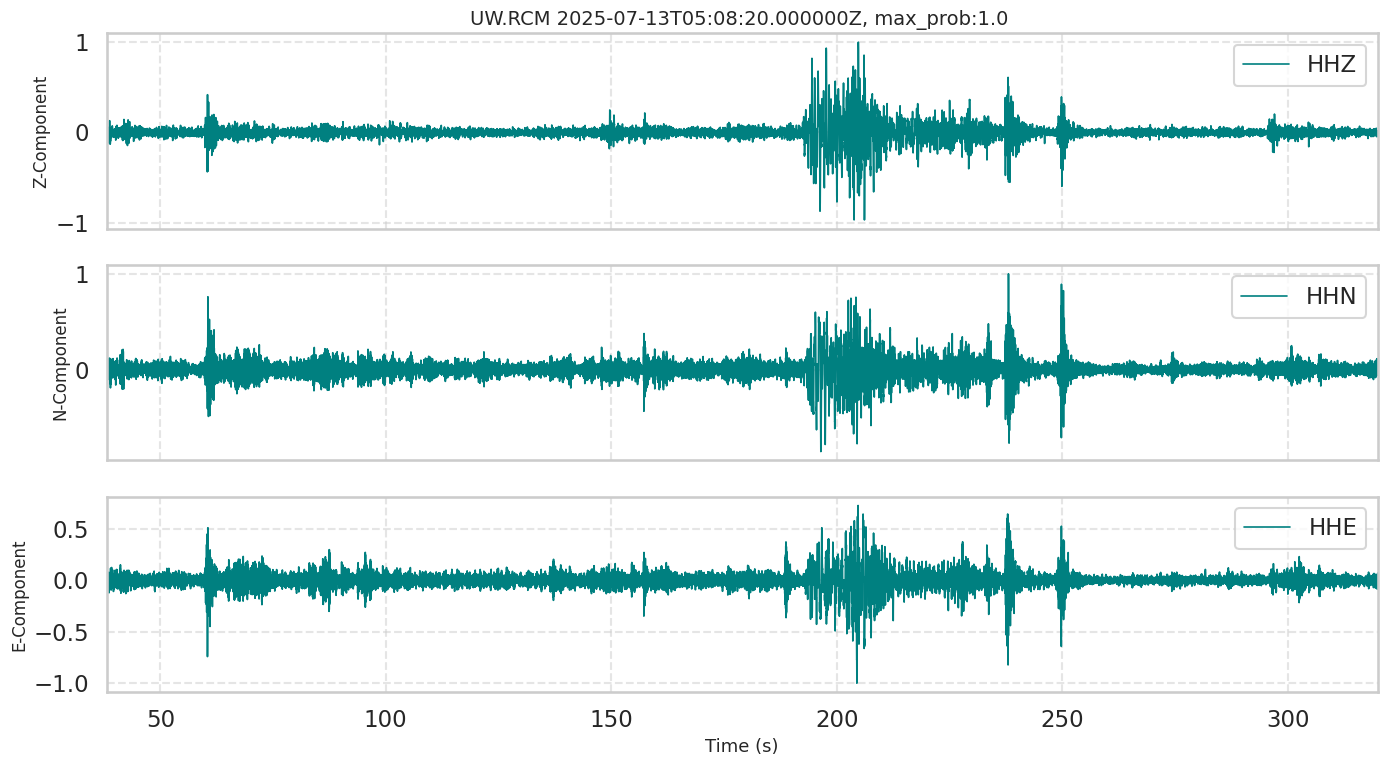

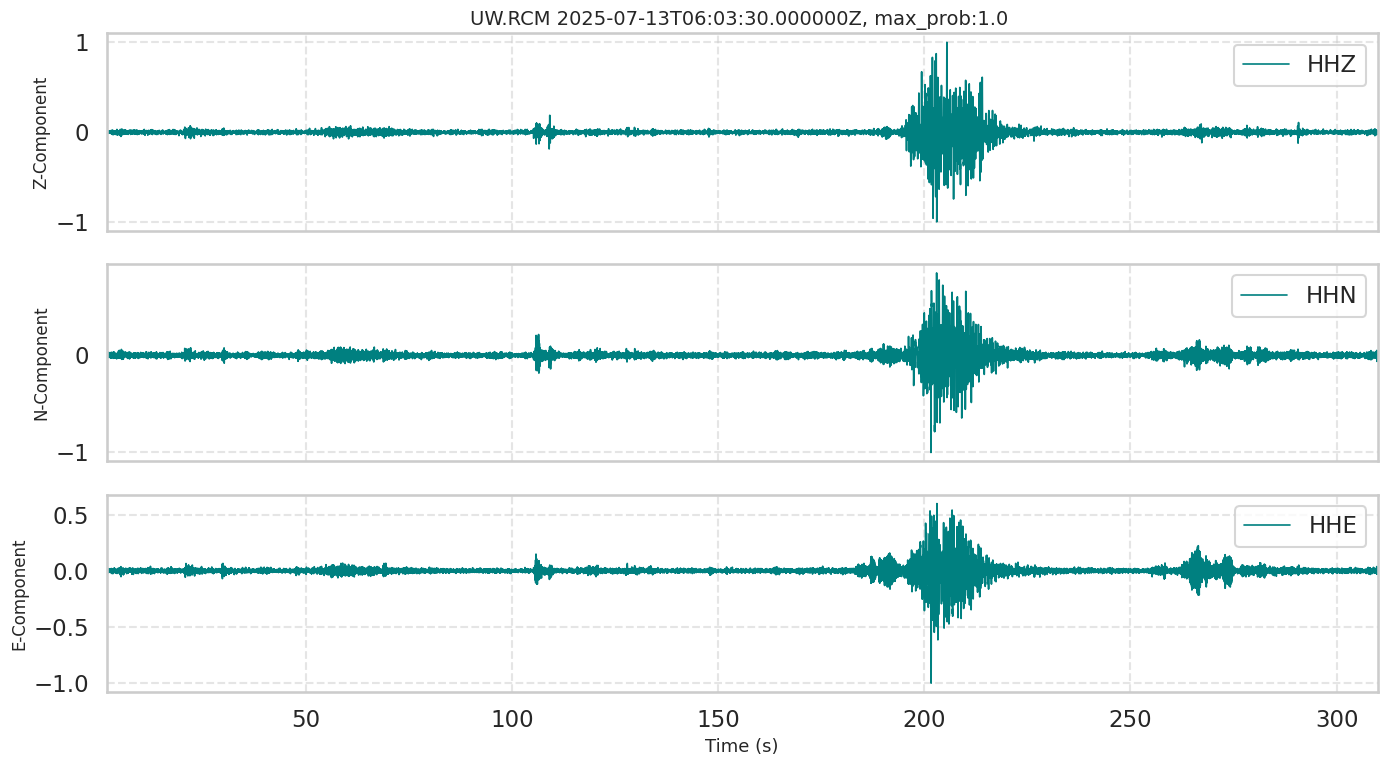

In [312]:
for i in range(len(high_conf_df)):

        network = 'UW'
        station = 'RCM'
        channel = '*H*'
        
        max_prob = np.around(high_conf_df['rcm_max_prob'].values[i],2)
        
        starttime = UTCDateTime(str(high_conf_df['starttime'].values[i])) - 100
        endtime = UTCDateTime(str(high_conf_df['endtime'].values[i])) +100

        # Get waveform and model probabilities
        st = client.get_waveforms(starttime=starttime, endtime=endtime,
                                  network=network, station=station,
                                  channel=channel, location=loc)


        st.detrend('linear')
        st.taper(0.001)
        st.filter('bandpass', freqmin = 1, freqmax = 20)






        st.merge(method=1)  # ensure a single continuous Trace per channel

        # Stack max amplitude time across all traces
        max_idx = np.argmax([np.max(np.abs(tr.data)) for tr in st])
        main_trace = st[np.argmax([np.max(np.abs(tr.data)) for tr in st])]
        peak_time = main_trace.times()[np.argmax(np.abs(main_trace.data))]

        # Set time window ±200s around peak
        x_min = max(0, peak_time - 200)
        x_max = min(main_trace.times()[-1], peak_time + 200)

        # Plot
        fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
        component_order = ['Z', 'N', 'E']

        for i, comp in enumerate(component_order):
            tr = [t for t in st if t.stats.channel[-1] == comp]
            if tr:
                tr = tr[0]
                t = tr.times()
                d = tr.data / np.max(np.abs(tr.data))  # normalize
                axs[i].plot(t, d, lw=1.2, label=f"{tr.stats.channel}", color="teal")
                axs[i].set_ylabel(f"{comp}-Component", fontsize=12)
                axs[i].grid(True, linestyle='--', alpha=0.5)
                axs[i].legend(loc="upper right")
            else:
                axs[i].set_visible(False)

        axs[2].set_xlabel("Time (s)", fontsize=13)
        axs[0].set_title(f"{network}.{station} {main_trace.stats.starttime}, max_prob:{max_prob} ", fontsize=14)
        plt.xlim(x_min, x_max)
        plt.tight_layout()
        plt.show()


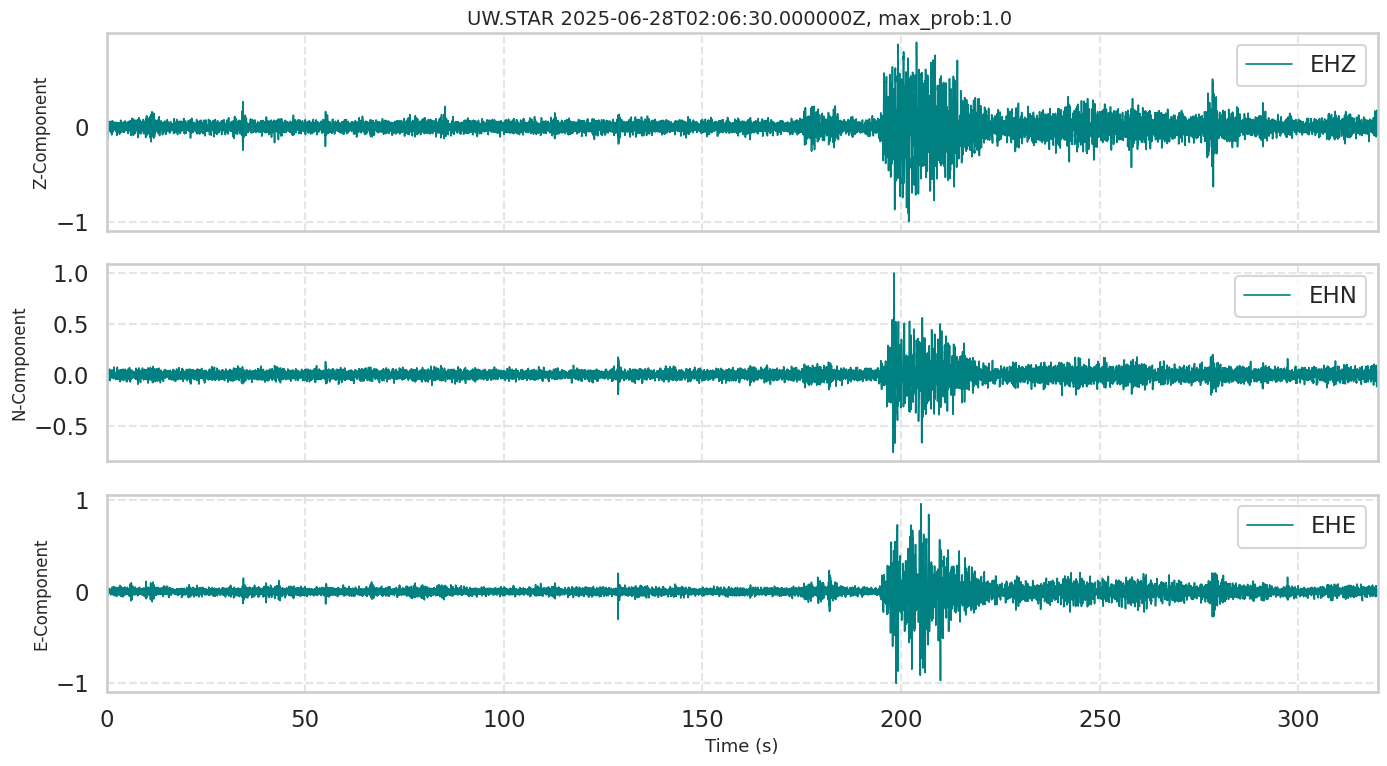

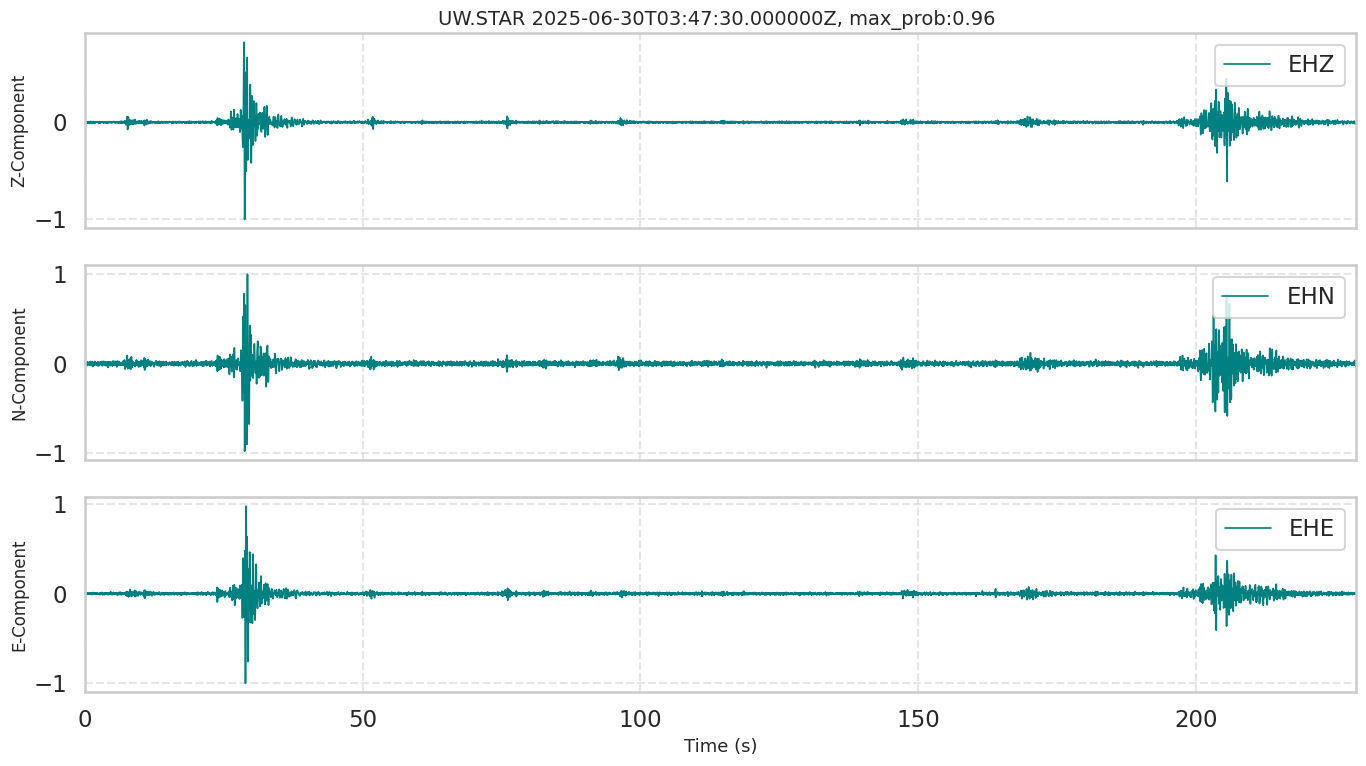

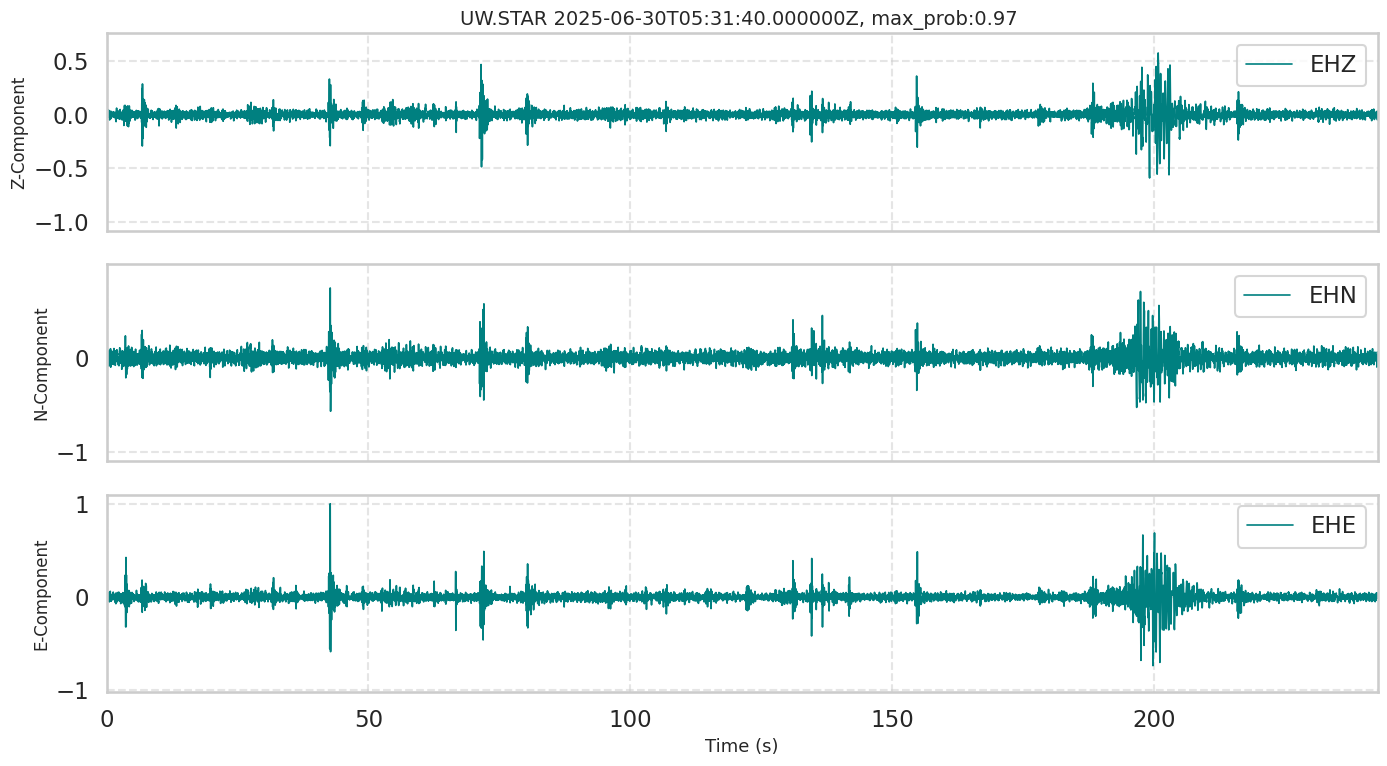

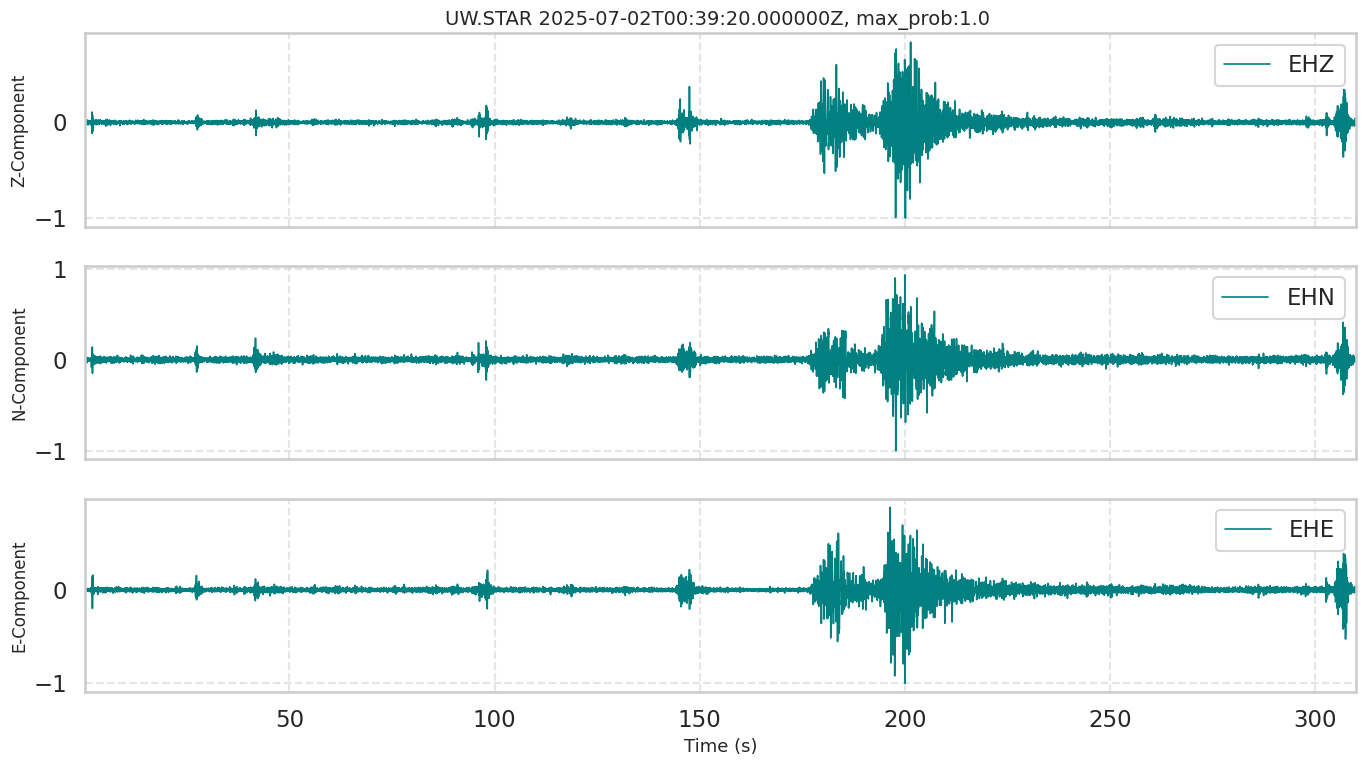

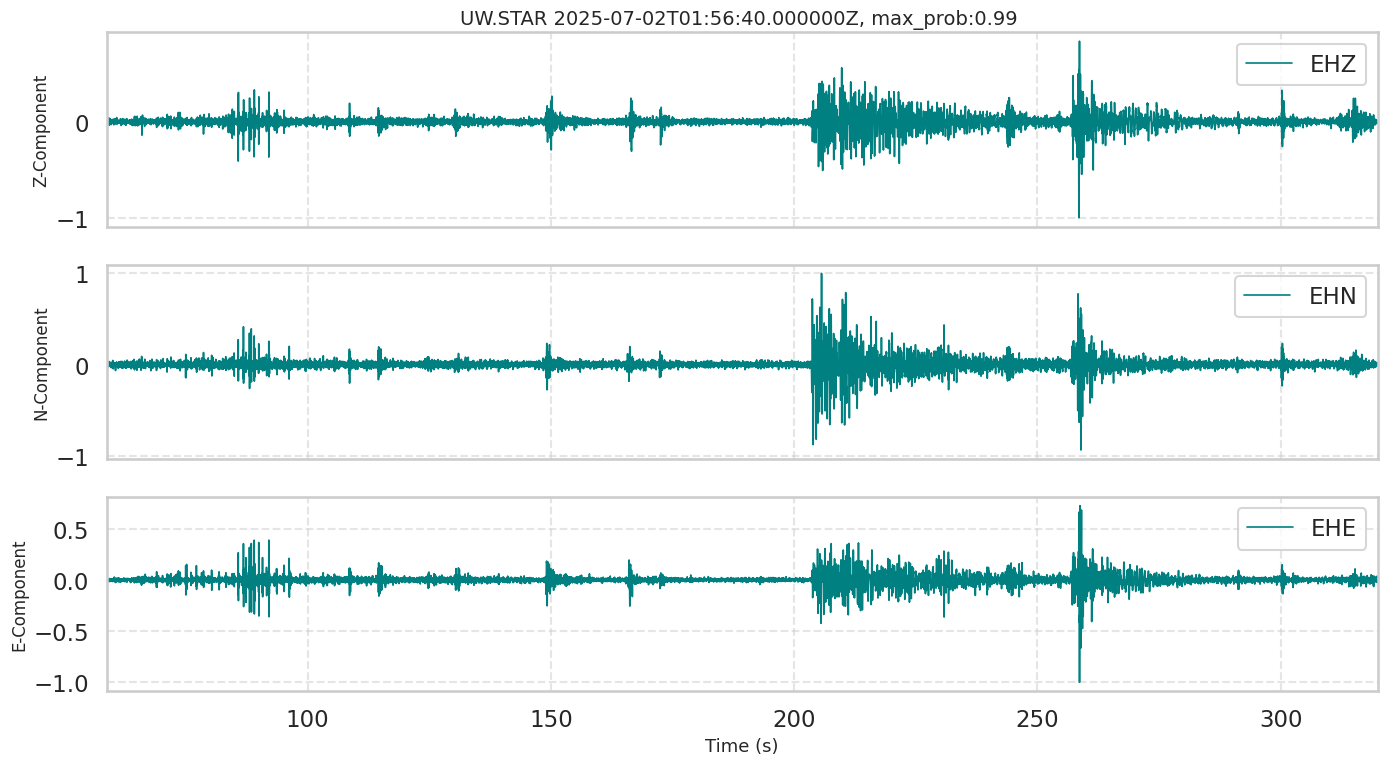

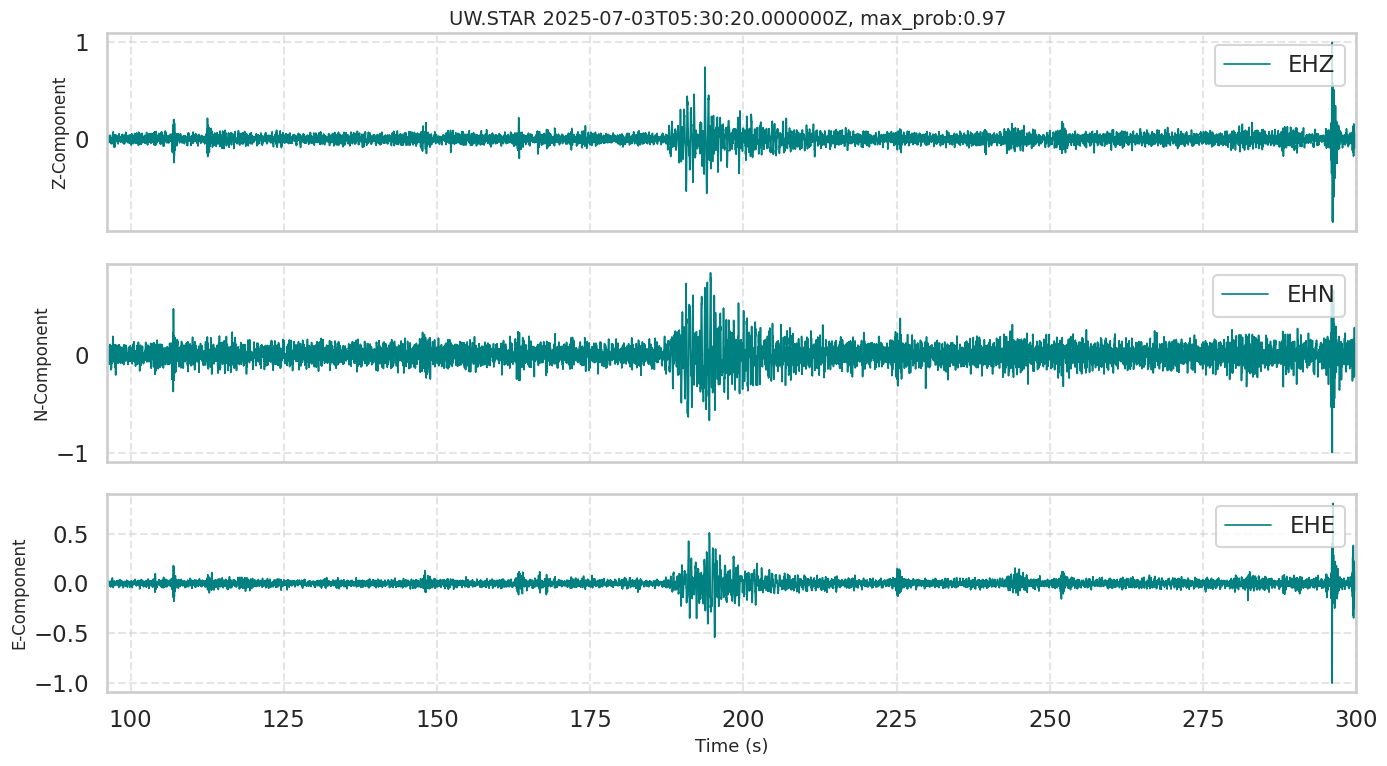

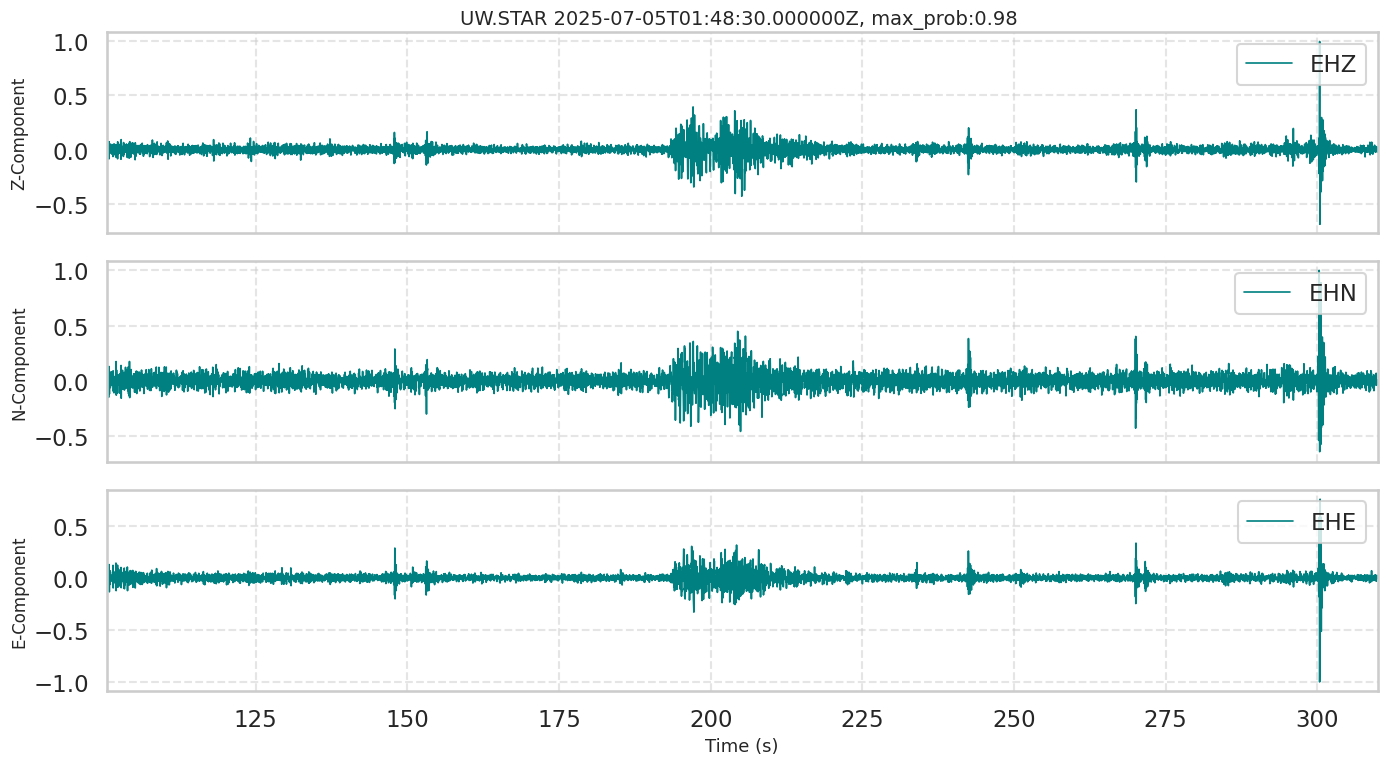

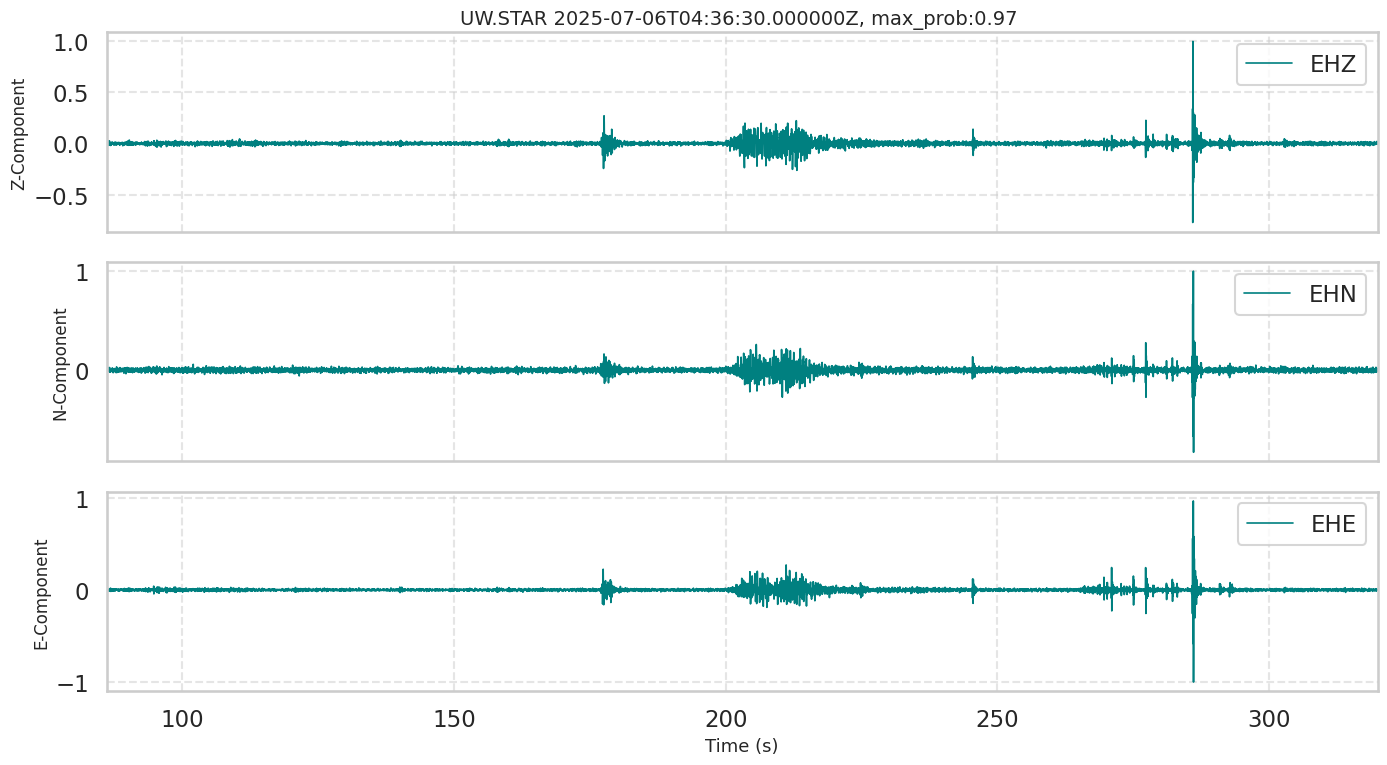

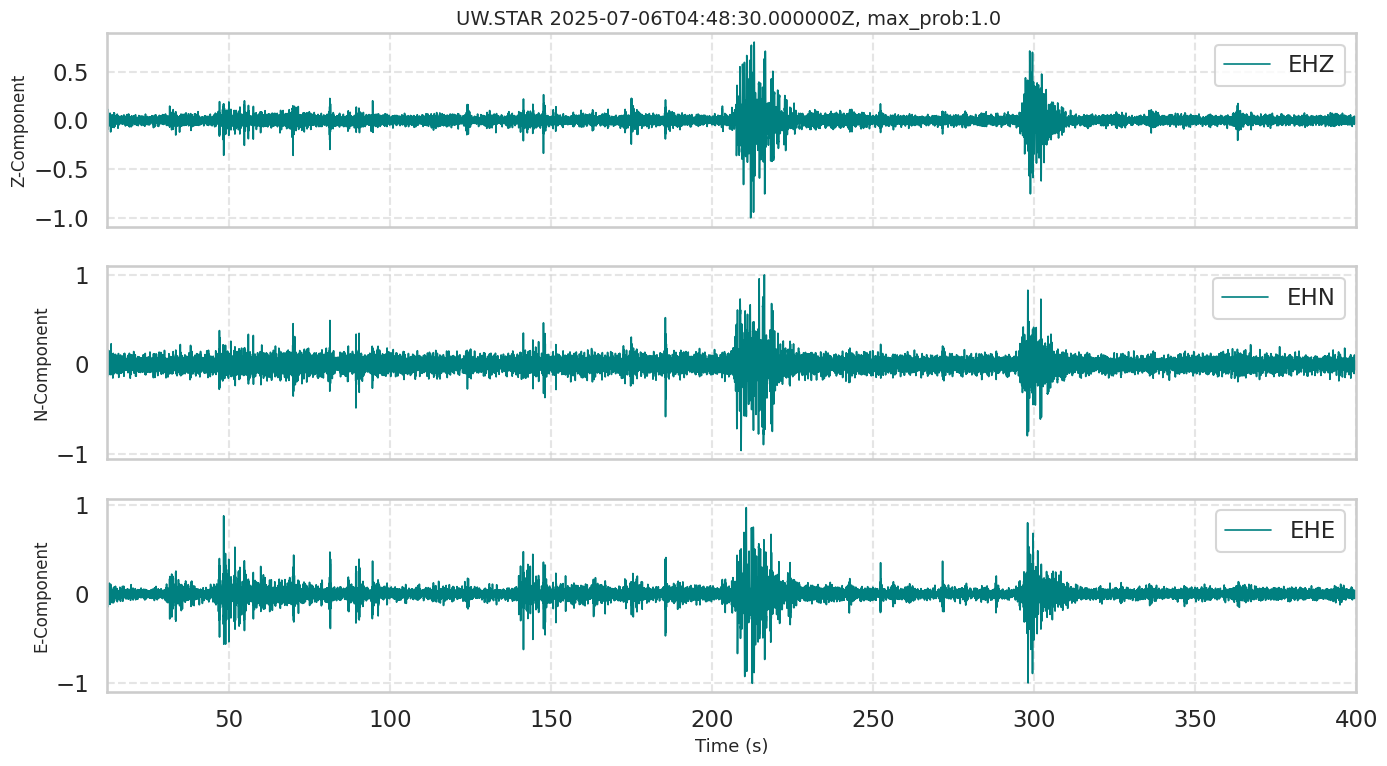

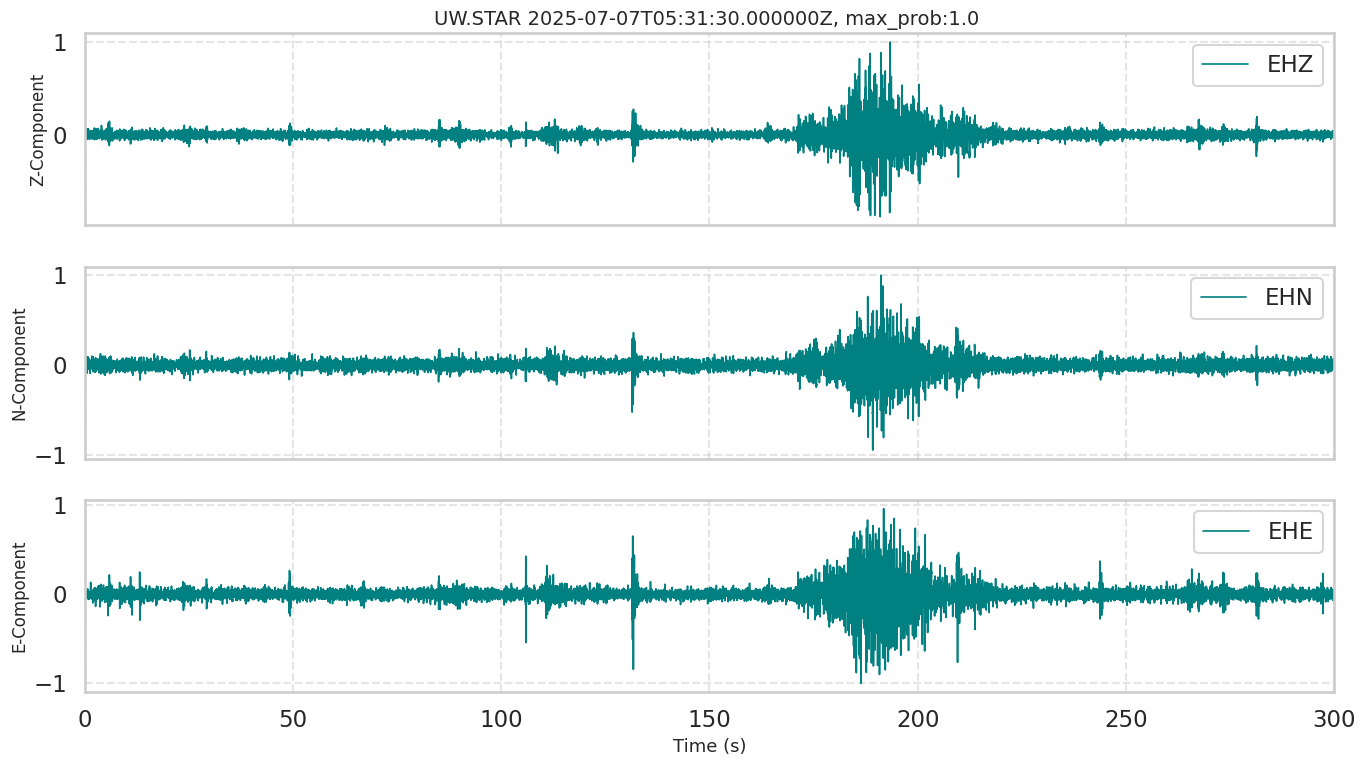

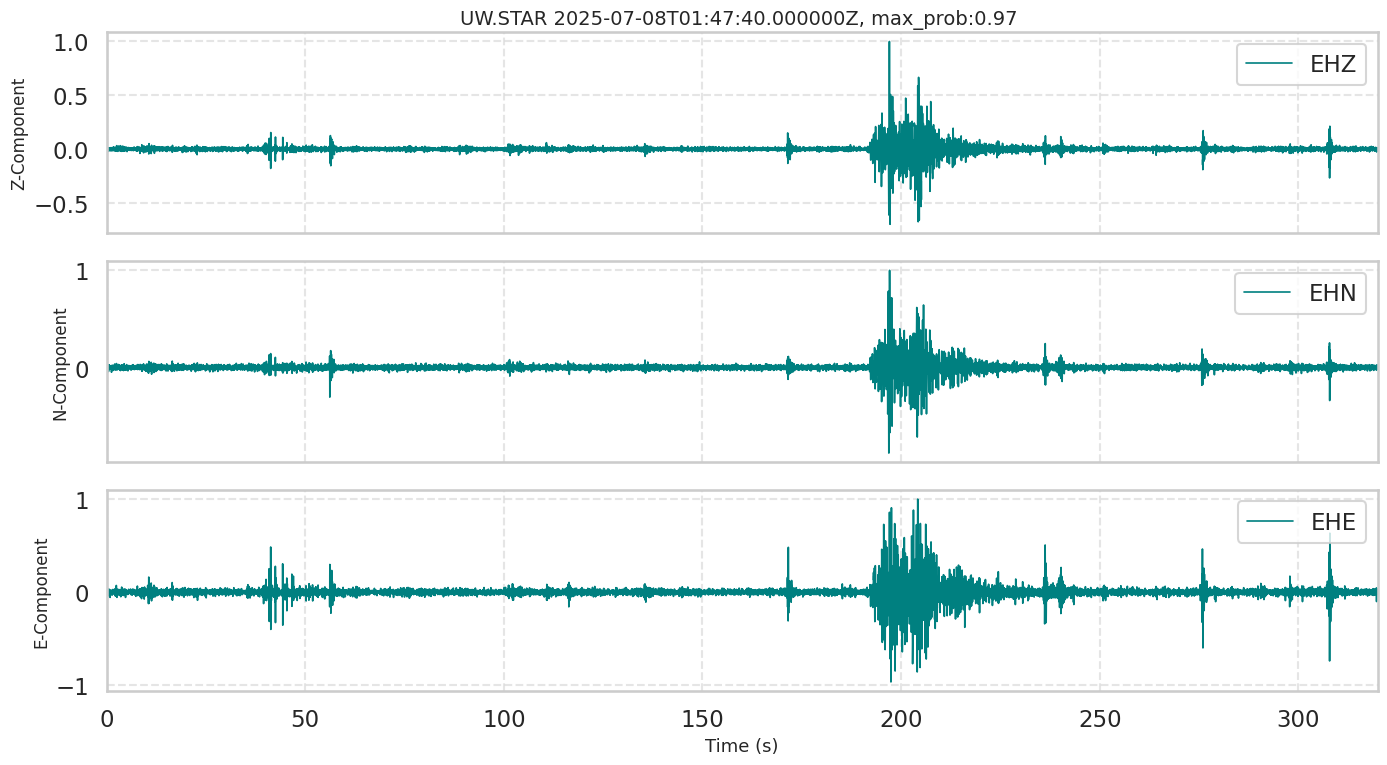

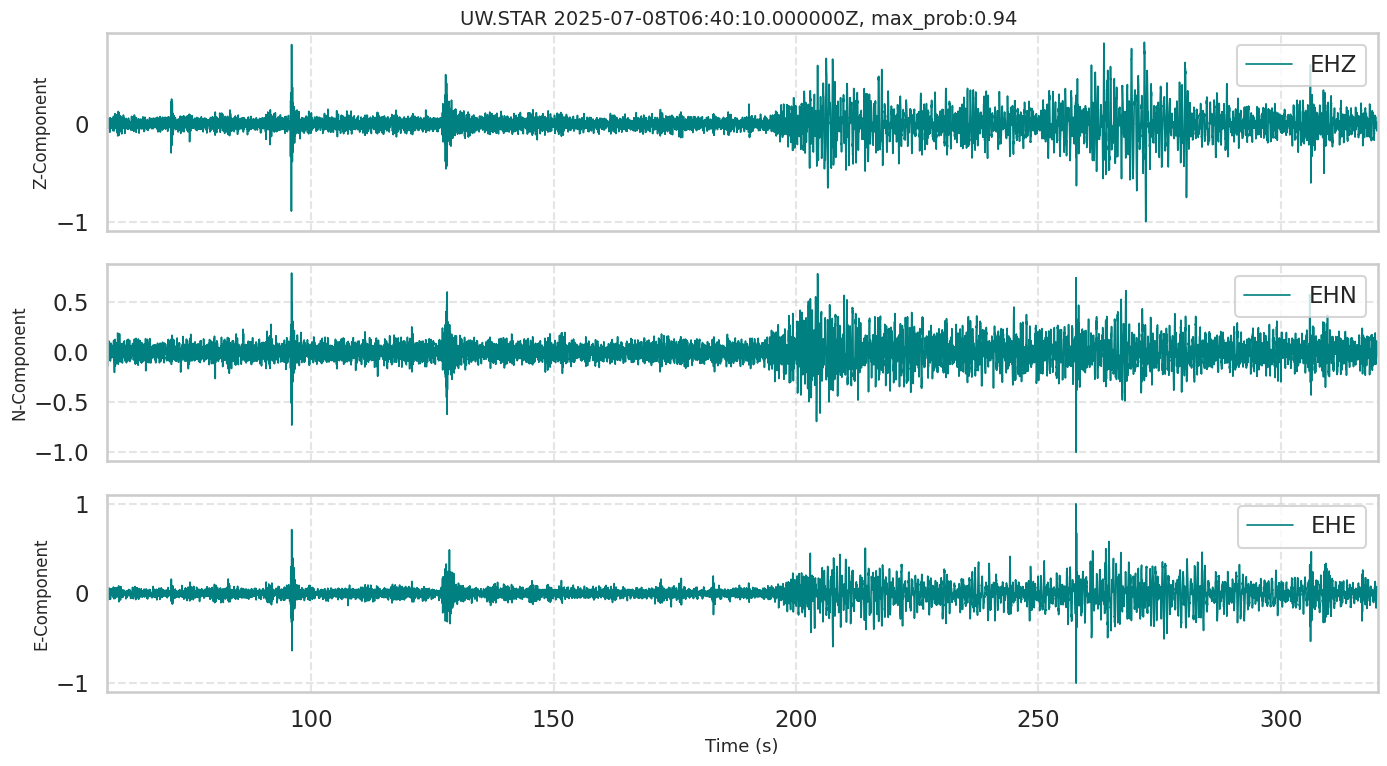

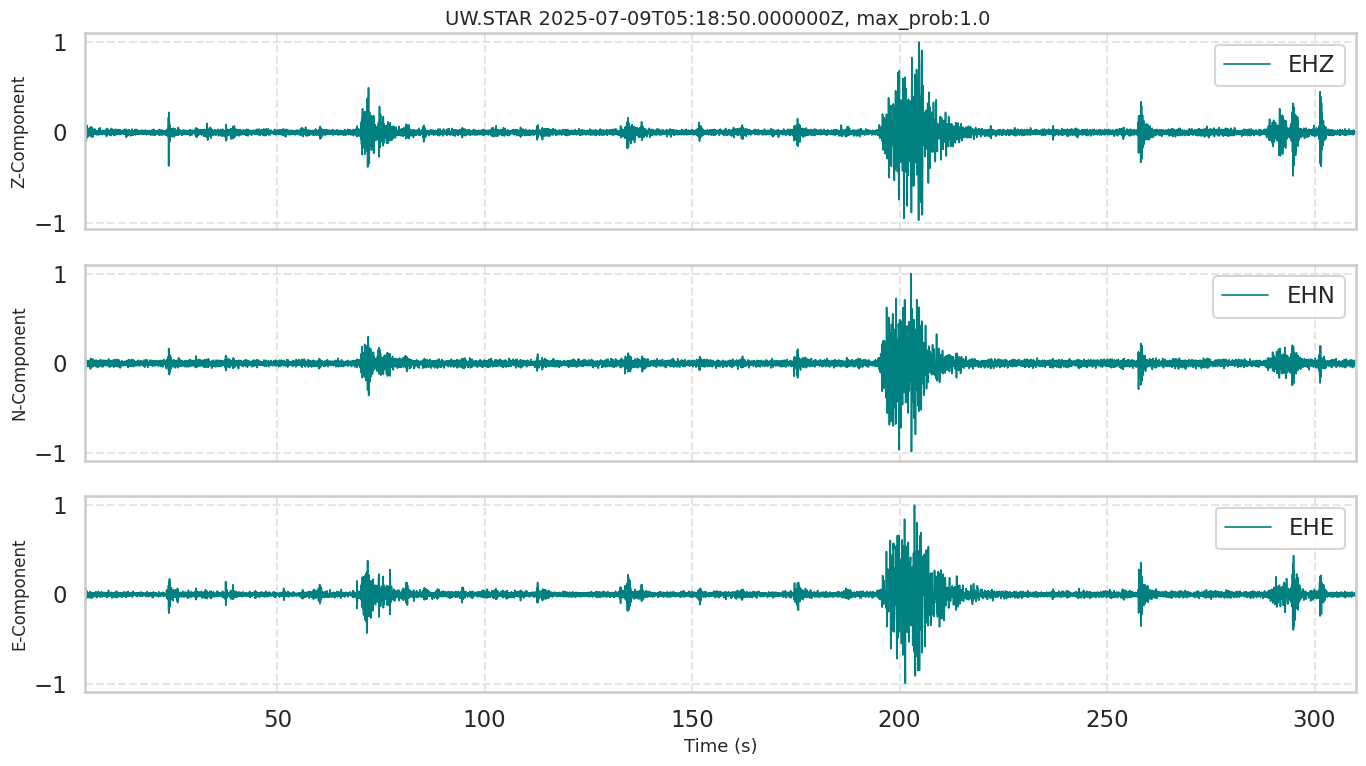

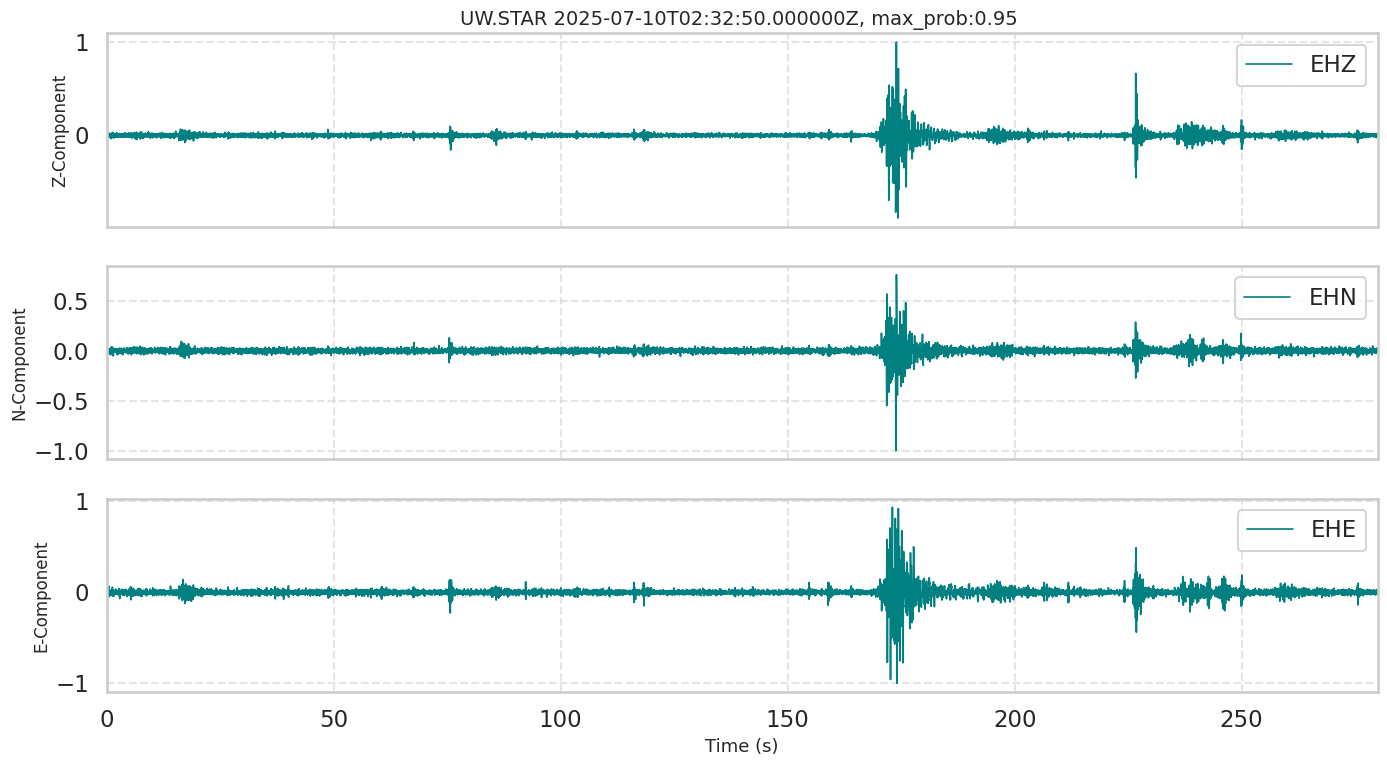

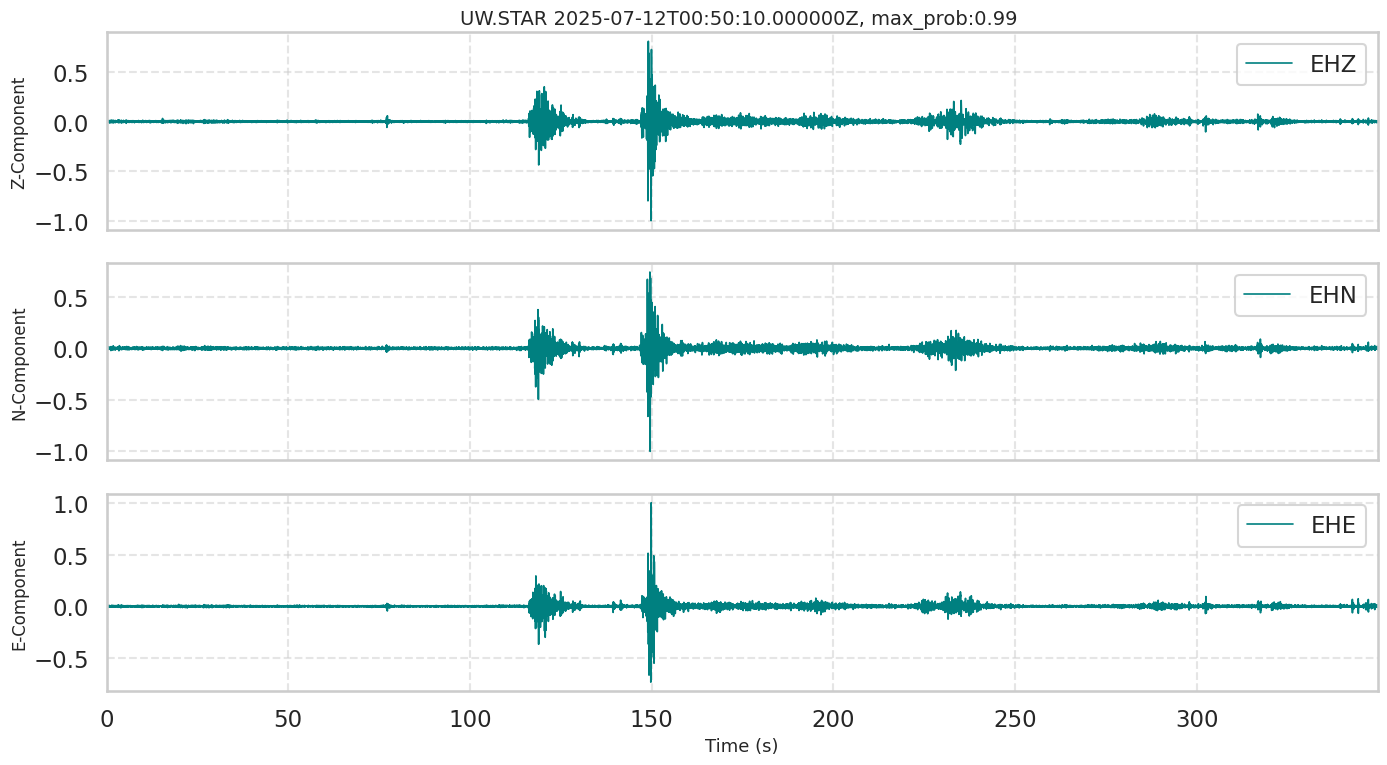

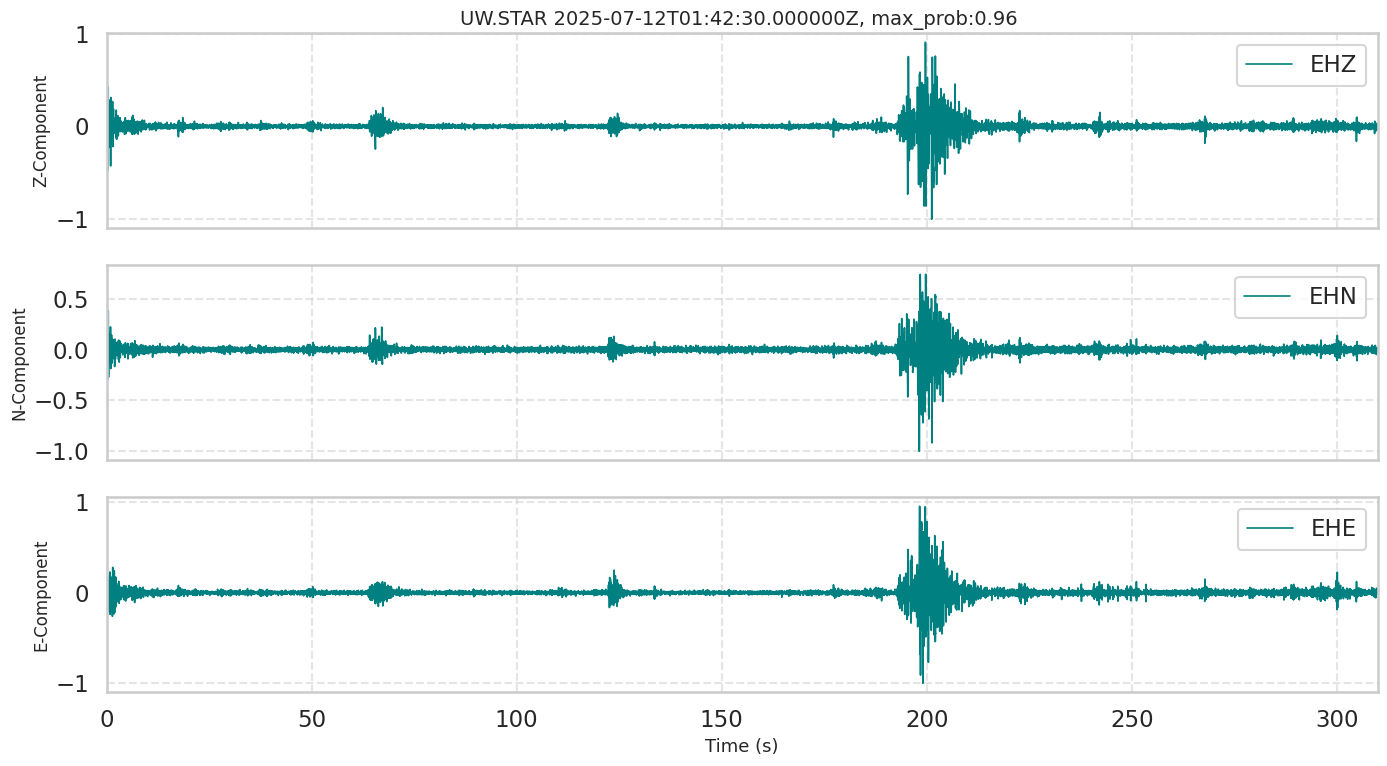

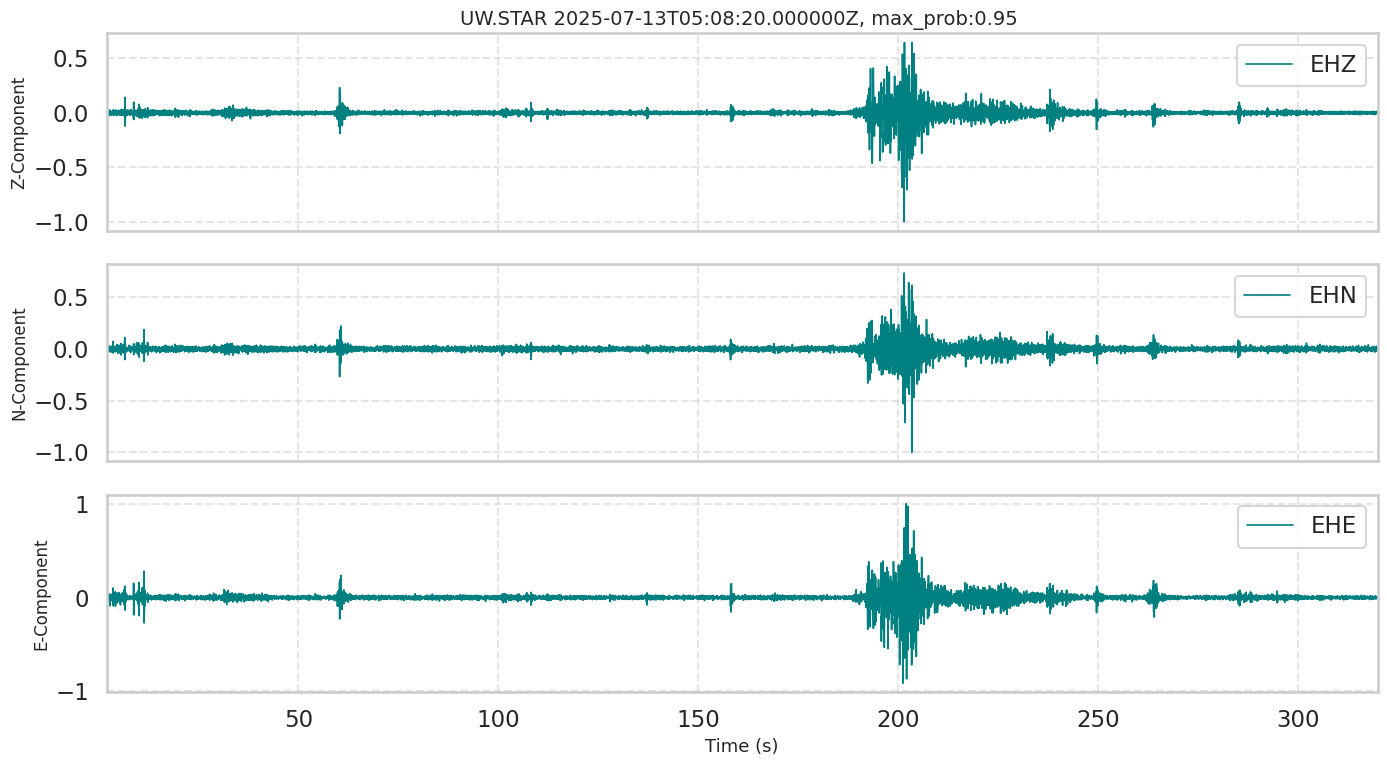

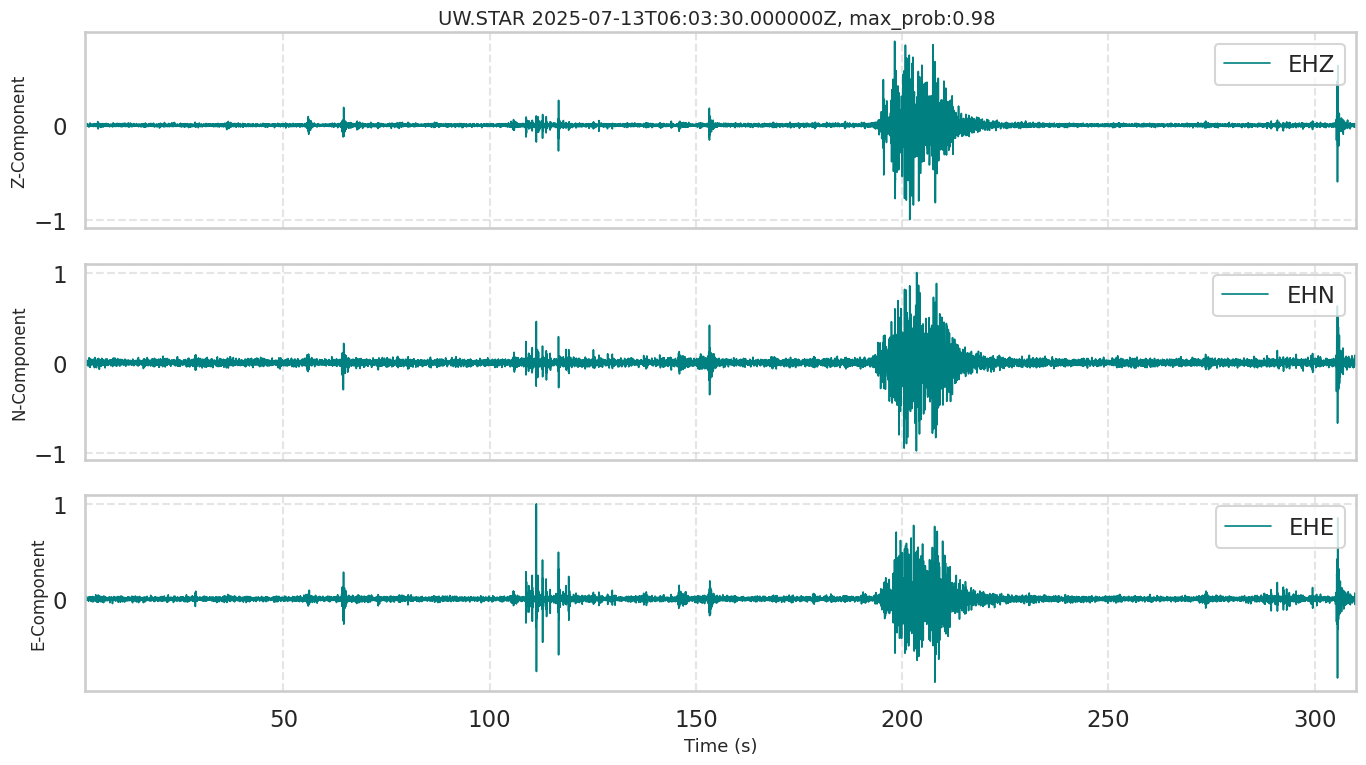

In [313]:
for i in range(len(high_conf_df)):

        network = 'UW'
        station = 'STAR'
        channel = '*H*'
        
        max_prob = np.around(high_conf_df['star_max_prob'].values[i],2)
        
        starttime = UTCDateTime(str(high_conf_df['starttime'].values[i])) - 100
        endtime = UTCDateTime(str(high_conf_df['endtime'].values[i])) +100

        # Get waveform and model probabilities
        st = client.get_waveforms(starttime=starttime, endtime=endtime,
                                  network=network, station=station,
                                  channel=channel, location=loc)


        st.detrend('linear')
        st.taper(0.001)
        st.filter('bandpass', freqmin = 1, freqmax = 20)






        st.merge(method=1)  # ensure a single continuous Trace per channel

        # Stack max amplitude time across all traces
        max_idx = np.argmax([np.max(np.abs(tr.data)) for tr in st])
        main_trace = st[np.argmax([np.max(np.abs(tr.data)) for tr in st])]
        peak_time = main_trace.times()[np.argmax(np.abs(main_trace.data))]

        # Set time window ±200s around peak
        x_min = max(0, peak_time - 200)
        x_max = min(main_trace.times()[-1], peak_time + 200)

        # Plot
        fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
        component_order = ['Z', 'N', 'E']

        for i, comp in enumerate(component_order):
            tr = [t for t in st if t.stats.channel[-1] == comp]
            if tr:
                tr = tr[0]
                t = tr.times()
                d = tr.data / np.max(np.abs(tr.data))  # normalize
                axs[i].plot(t, d, lw=1.2, label=f"{tr.stats.channel}", color="teal")
                axs[i].set_ylabel(f"{comp}-Component", fontsize=12)
                axs[i].grid(True, linestyle='--', alpha=0.5)
                axs[i].legend(loc="upper right")
            else:
                axs[i].set_visible(False)

        axs[2].set_xlabel("Time (s)", fontsize=13)
        axs[0].set_title(f"{network}.{station} {main_trace.stats.starttime}, max_prob:{max_prob} ", fontsize=14)
        plt.xlim(x_min, x_max)
        plt.tight_layout()
        plt.show()
